In [1]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_file
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os
import glob
import pandas 
import h5py
import cvlib as cv







In [2]:
class SmallerVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(128, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(classes))
        model.add(Activation("sigmoid"))

        return model


In [3]:
def generate_h5_data(data,labels,filename):
    assert(type(filename) is str)
    assert(len(data) == len(labels)) 
    try:
        filepath= f'./{filename}.h5'


        h5data = h5py.File(filepath, 'w')
        h5data.create_dataset('image',data= data)
        h5data['label'] = labels


    finally:
        h5data.close()

#NO NEED FOR THIS EXERCISE
def load_h5_data(h5filepath):
    h5file = h5py.File(h5filepath, "r")
    try:
        x_fieldname,y_fieldname, = h5file.keys()   #this order is Gfriend files
        print("The keys are: ", h5file.keys())
        data = np.array(h5file['image'][:]) # your test set features
        labels = np.array(h5file['label'][:]) # your test set labels
        print("The shape of x_field",data.shape)
        print("The shape of y_field",labels.shape)
    finally:
        h5file.close()
    return data, labels


In [4]:
def show_20_images(img_array,label_array,offset=0):
    
    assert(len(img_array)==len(label_array))
    
    datalen = len(img_array)
    numOfIter = min(datalen,20)
    
    if numOfIter < 20:
        offset = 0  #if numOfIter < 20, it means it equals datalen, which is less than 20 fed in. So no need offset
        
    numOfRow = numOfIter//4 + (numOfIter%4 != 0)   #a ceiling function
    
    plt.rcParams['figure.figsize'] = (60.0, 100.0) 
    print(img_array.shape)
    num_px = img_array.shape[1] #shape is (m, num_px,num_px,3)
    for i in range(numOfIter):
        plt.subplot(5,4,i+1)  #plot 5 by 4 grid
        #plt.imshow(img_array[i+offset])
        plt.imshow(img_array[i+offset].reshape(num_px,num_px,3), interpolation='nearest')  #take only the num_px
        plt.axis('off')
        #print(f'IMG {i+1} is labelled {label_array[i+offset]}')
        _class = "Male" if label_array[i+offset] == 0 else "Female"
        plt.title("Class: " + _class,fontsize = 50)

In [5]:
epochs = 100
lr = 1e-3
batch_size = 64
img_dims = (96,96,3)

# SmallerVGG trained on Adience

In [6]:
df1 = pandas.read_table('label.txt', sep="\s+")
df1.columns = ['original_image', 'face_id', 'age_lower', 'age_higher', 'gender', 'x', 'y', 'dx', 'dy', 'tilt_ang', 'fiducial_yaw_angle', 'fiducial_score']
print(df1)

                            original_image  face_id age_lower age_higher  \
30601258@N03  10399646885_67c7d20df9_o.jpg        1      (25,        32)   
30601258@N03  10424815813_e94629b1ec_o.jpg        2      (25,        32)   
30601258@N03  10437979845_5985be4b26_o.jpg        1      (25,        32)   
30601258@N03  10437979845_5985be4b26_o.jpg        3      (25,        32)   
30601258@N03  11816644924_075c3d8d59_o.jpg        2      (25,        32)   
...                                    ...      ...       ...        ...   
7153718@N04   11598838386_349a0d4849_o.jpg     2282      None        596   
7153718@N04   11598166203_c70bb34c80_o.jpg     2283      None       1179   
7153718@N04   11598166203_c70bb34c80_o.jpg     2282      None       1201   
7153718@N04   11598145163_733cb99713_o.jpg     2282      None       1027   
7153718@N04   11598013005_240c2bc9c7_o.jpg     2282      None        498   

             gender     x     y    dx    dy  tilt_ang  fiducial_yaw_angle  \
30601258@N

In [7]:
data = []
labels = []

In [8]:
image_files2 = [f for f in glob.glob("aligned" + "/**/*", recursive=True) if not os.path.isdir(f)] 
random.seed(42)
random.shuffle(image_files2)
s=os.path.basename(image_files2[1])
print(s)
parts = s.split(".")
face_id=parts[1]
original_image=parts[2]+'.'+parts[3]
print(original_image)
print(face_id)
df2=df1[df1.age_lower != 'None']
print(df2)
dflock_img=df2.loc[df2['original_image'] == original_image]
print(dflock_img)
dflock_img_id=dflock_img.loc[dflock_img['face_id'] == int(face_id)]
print(dflock_img_id)
print(dflock_img_id['age_lower'].to_string(index=False))
print(dflock_img_id['gender'].to_string(index=False))
print(dflock_img_id['gender'].to_string(index=False)==' m')

landmark_aligned_face.661.10044916713_9f5eb490bc_o.jpg
10044916713_9f5eb490bc_o.jpg
661
                             original_image  face_id age_lower age_higher  \
30601258@N03   10399646885_67c7d20df9_o.jpg        1      (25,        32)   
30601258@N03   10424815813_e94629b1ec_o.jpg        2      (25,        32)   
30601258@N03   10437979845_5985be4b26_o.jpg        1      (25,        32)   
30601258@N03   10437979845_5985be4b26_o.jpg        3      (25,        32)   
30601258@N03   11816644924_075c3d8d59_o.jpg        2      (25,        32)   
...                                     ...      ...       ...        ...   
101515718@N03  10587826073_6663f5b654_o.jpg     2280      (25,        32)   
101515718@N03  10587571495_a61785cd06_o.jpg     2278      (25,        32)   
101515718@N03  10587571495_a61785cd06_o.jpg     2279      (25,        32)   
50458575@N08    9426695459_9e8b347604_o.jpg     2281      (25,        32)   
50458575@N08    9429464468_1bfc39ecfb_o.jpg     2281      (25,   

In [ ]:
# create groud-truth label from the image path
for img in image_files2:
    s=os.path.basename(img)
    parts = s.split(".")
    face_id=parts[1]
    original_image=parts[2]+'.'+parts[3]
    dflock_img=df2.loc[df2['original_image'] == original_image]
    dflock_img_id=dflock_img.loc[dflock_img['face_id'] == int(face_id)]
    if dflock_img_id.empty:
        continue
    else:
        image = cv2.imread(img)
        image = cv2.resize(image, (img_dims[0],img_dims[1]))
        image = img_to_array(image)
        data.append(image)
        if dflock_img_id['gender'].to_string(index=False)==" f":
            label = 1
        else:
            label = 0
        labels.append([label])





In [ ]:
# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

#generate_h5_data(data,labels,"I_LUV_U")   
print('x_data shape:', data.shape)
print('x_data shape:', labels.shape)


The keys are:  <KeysViewHDF5 ['image', 'label']>
The shape of x_field (18622, 96, 96, 3)
The shape of y_field (18622, 1)
(18622, 96, 96, 3)


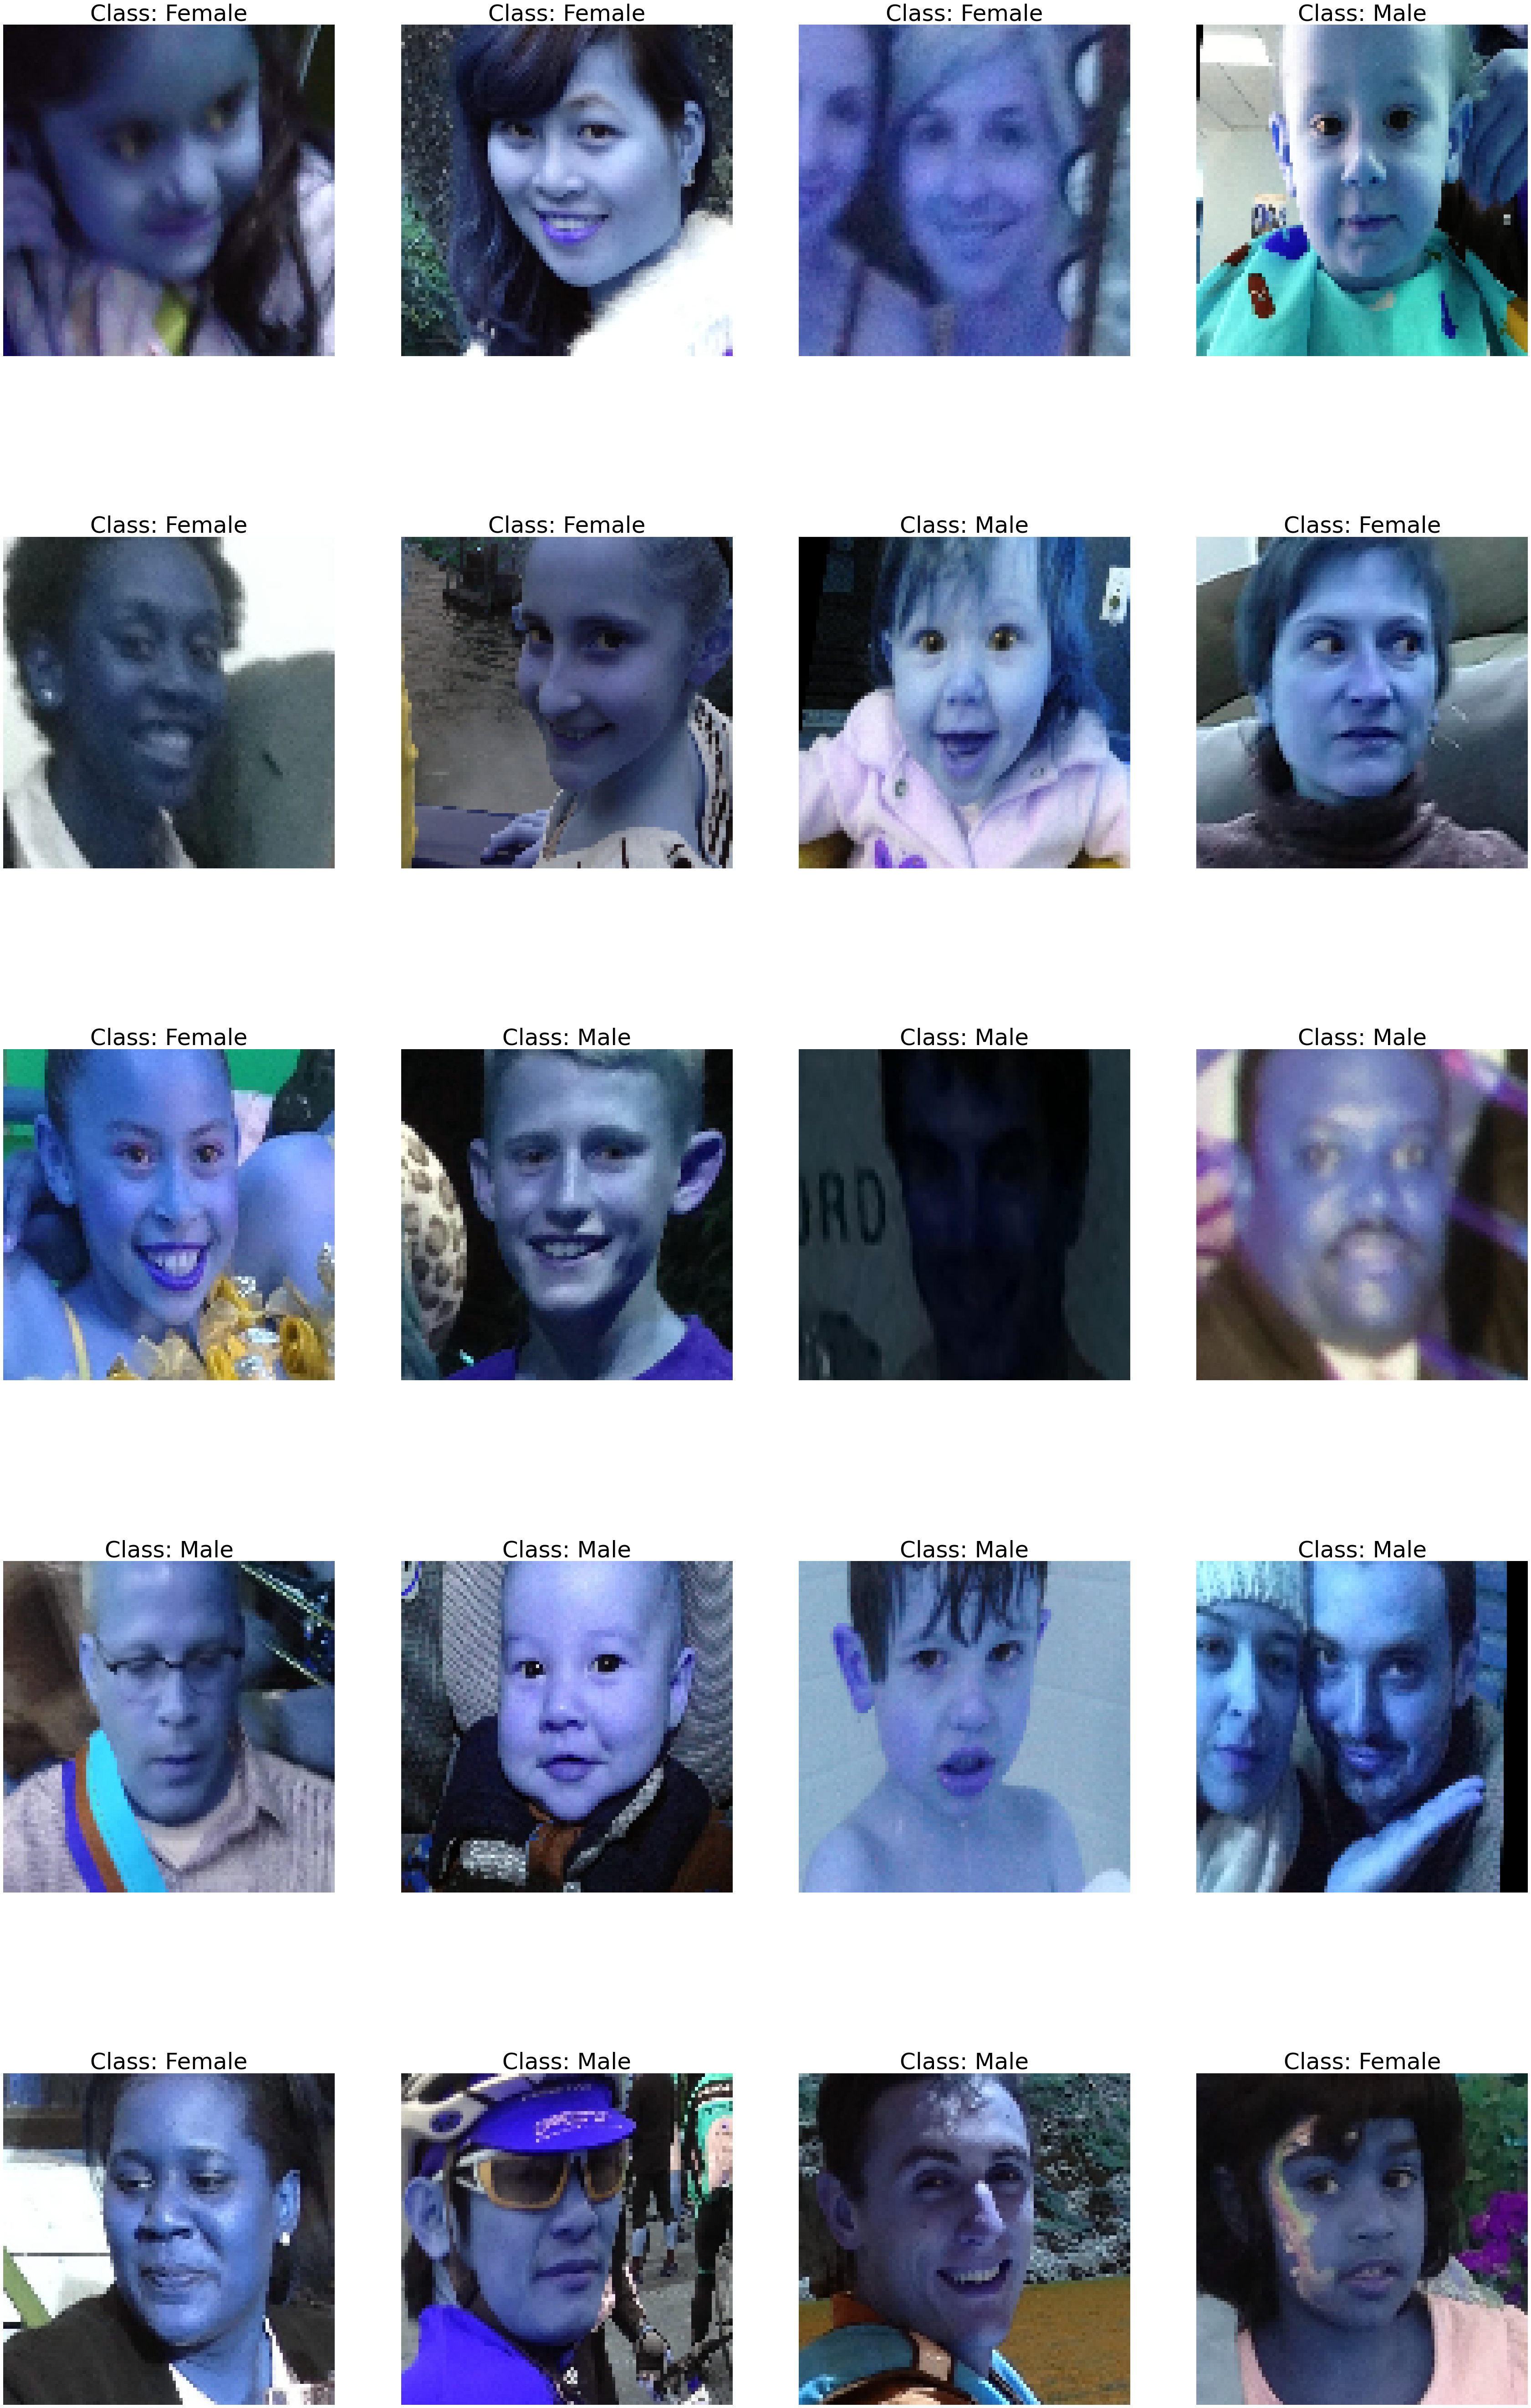

In [9]:
#Can skip the above data prep and run this to save time 
#data,labels=load_h5_data("I_LUV_U.h5")
show_20_images(data,labels,20)

In [40]:
with open('labelout.txt', 'w') as f:
    for item in labels:
        f.write("%s\n" % item)

In [7]:
# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
232/232 [==============================] - 30s 128ms/step - loss: 0.8014 - accuracy: 0.6046 - val_loss: 0.8090 - val_accuracy: 0.4864
Epoch 2/100
232/232 [==============================] - 29s 125ms/step - loss: 0.6706 - accuracy: 0.6502 - val_loss: 0.6330 - val_accuracy: 0.6542
Epoch 3/100
232/232 [==============================] - 29s 125ms/step - loss: 0.6148 - accuracy: 0.6798 - val_loss: 0.5744 - val_accuracy: 0.6956
Epoch 4/100
232/232 [==============================] - 29s 126ms/step - loss: 0.5805 - accuracy: 0.7022 - val_loss: 0.5530 - val_accuracy: 0.7224
Epoch 5/100
232/232 [==============================] - 31s 133ms/step - loss: 0.5603 - accuracy: 0.7168 - val_loss: 0.5300 - val_accuracy: 0.7393
Epoch 6/100
232/232 [==============================] - 32s 140ms/step - loss: 0.5345 - accuracy: 0.7362 - val_loss: 0.4986 - val_accuracy: 0.7627
Epoch 7/100
232/232 [===========================

232/232 [==============================] - 29s 127ms/step - loss: 0.2514 - accuracy: 0.8971 - val_loss: 0.2547 - val_accuracy: 0.8956
Epoch 56/100
232/232 [==============================] - 29s 127ms/step - loss: 0.2455 - accuracy: 0.8971 - val_loss: 0.2874 - val_accuracy: 0.8878
Epoch 57/100
232/232 [==============================] - 30s 129ms/step - loss: 0.2405 - accuracy: 0.9019 - val_loss: 0.2618 - val_accuracy: 0.8980
Epoch 58/100
232/232 [==============================] - 30s 129ms/step - loss: 0.2518 - accuracy: 0.8972 - val_loss: 0.2823 - val_accuracy: 0.8862
Epoch 59/100
232/232 [==============================] - 29s 126ms/step - loss: 0.2426 - accuracy: 0.9018 - val_loss: 0.2581 - val_accuracy: 0.8940
Epoch 60/100
232/232 [==============================] - 29s 125ms/step - loss: 0.2437 - accuracy: 0.9003 - val_loss: 0.2438 - val_accuracy: 0.9039
Epoch 61/100
232/232 [==============================] - 29s 125ms/step - loss: 0.2403 - accuracy: 0.9007 - val_loss: 0.2529 - val_a

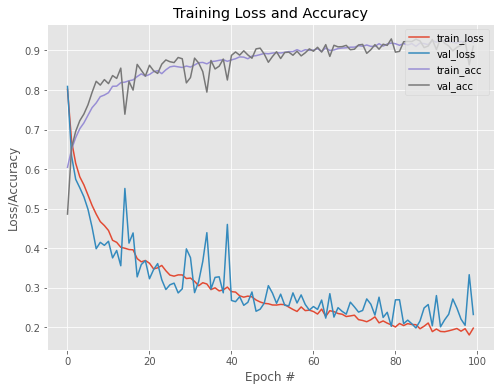

<Figure size 4320x7200 with 0 Axes>

In [8]:
# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

# build model
Adience_model = SmallerVGGNet.build(width=img_dims[0], height=img_dims[1], depth=img_dims[2],
                            classes=2)
# compile the model, need to reduce lr to reduce overfit
opt = Adam(lr=lr, decay=lr/epochs)
Adience_model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the model
H = Adience_model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, verbose=1)

# save the model to disk
Adience_model.save("my_model2")

# plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.show()
# save plot to disk
plt.savefig("my_figures2")


# SmallerVGG trained on Adience (Pretraining using CelebA)

## Pretraining with CelebA

In [10]:
df = pandas.read_table('list_attr_celeba.txt', delim_whitespace=True)
print(df)

          Filename  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
0       000001.jpg                -1                1           1   
1       000002.jpg                -1               -1          -1   
2       000003.jpg                -1               -1          -1   
3       000004.jpg                -1               -1           1   
4       000005.jpg                -1                1           1   
...            ...               ...              ...         ...   
202594  202595.jpg                -1               -1           1   
202595  202596.jpg                -1               -1          -1   
202596  202597.jpg                -1               -1          -1   
202597  202598.jpg                -1                1           1   
202598  202599.jpg                -1                1           1   

        Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  \
0                    -1    -1     -1        -1        -1          -1  ...   
1                

In [11]:
# initial parameters
num_images = 20000
i = 1
data = []
labels = []

In [12]:
# load image files from the dataset
image_files = [f for f in glob.glob("img_align_celeba" + "/**/*", recursive=True) if not os.path.isdir(f)] 
random.seed(42)
random.shuffle(image_files)
dflock=df.loc[df['Filename'] == os.path.basename(image_files[0])]
print(dflock['Male'].to_string(index=False))
if dflock['Male'].to_string(index=False)=="-1":
    print('Female')

-1
Female


In [ ]:
# create groud-truth label from the image path
for img in image_files:
    if i > num_images:
        break
    else:
        dflock=df.loc[df['Filename'] == os.path.basename(img)]
        image = cv2.imread(img)
        image = cv2.resize(image, (img_dims[0],img_dims[1]))
        image = img_to_array(image)
        data.append(image)
        if dflock['Male'].to_string(index=False)=="-1":
            label = 1
        else:
            label = 0
        labels.append([label])
        i+=1
    

In [18]:
# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels) 


#generate_h5_data(data,labels,"I_LUV_U_2")  


In [13]:
#Can skip the above data prep and run this to save time 
#data,labels=load_h5_data("I_LUV_U_2.h5")

The keys are:  <KeysViewHDF5 ['image', 'label']>
The shape of x_field (20000, 96, 96, 3)
The shape of y_field (20000, 1)


(20000, 96, 96, 3)


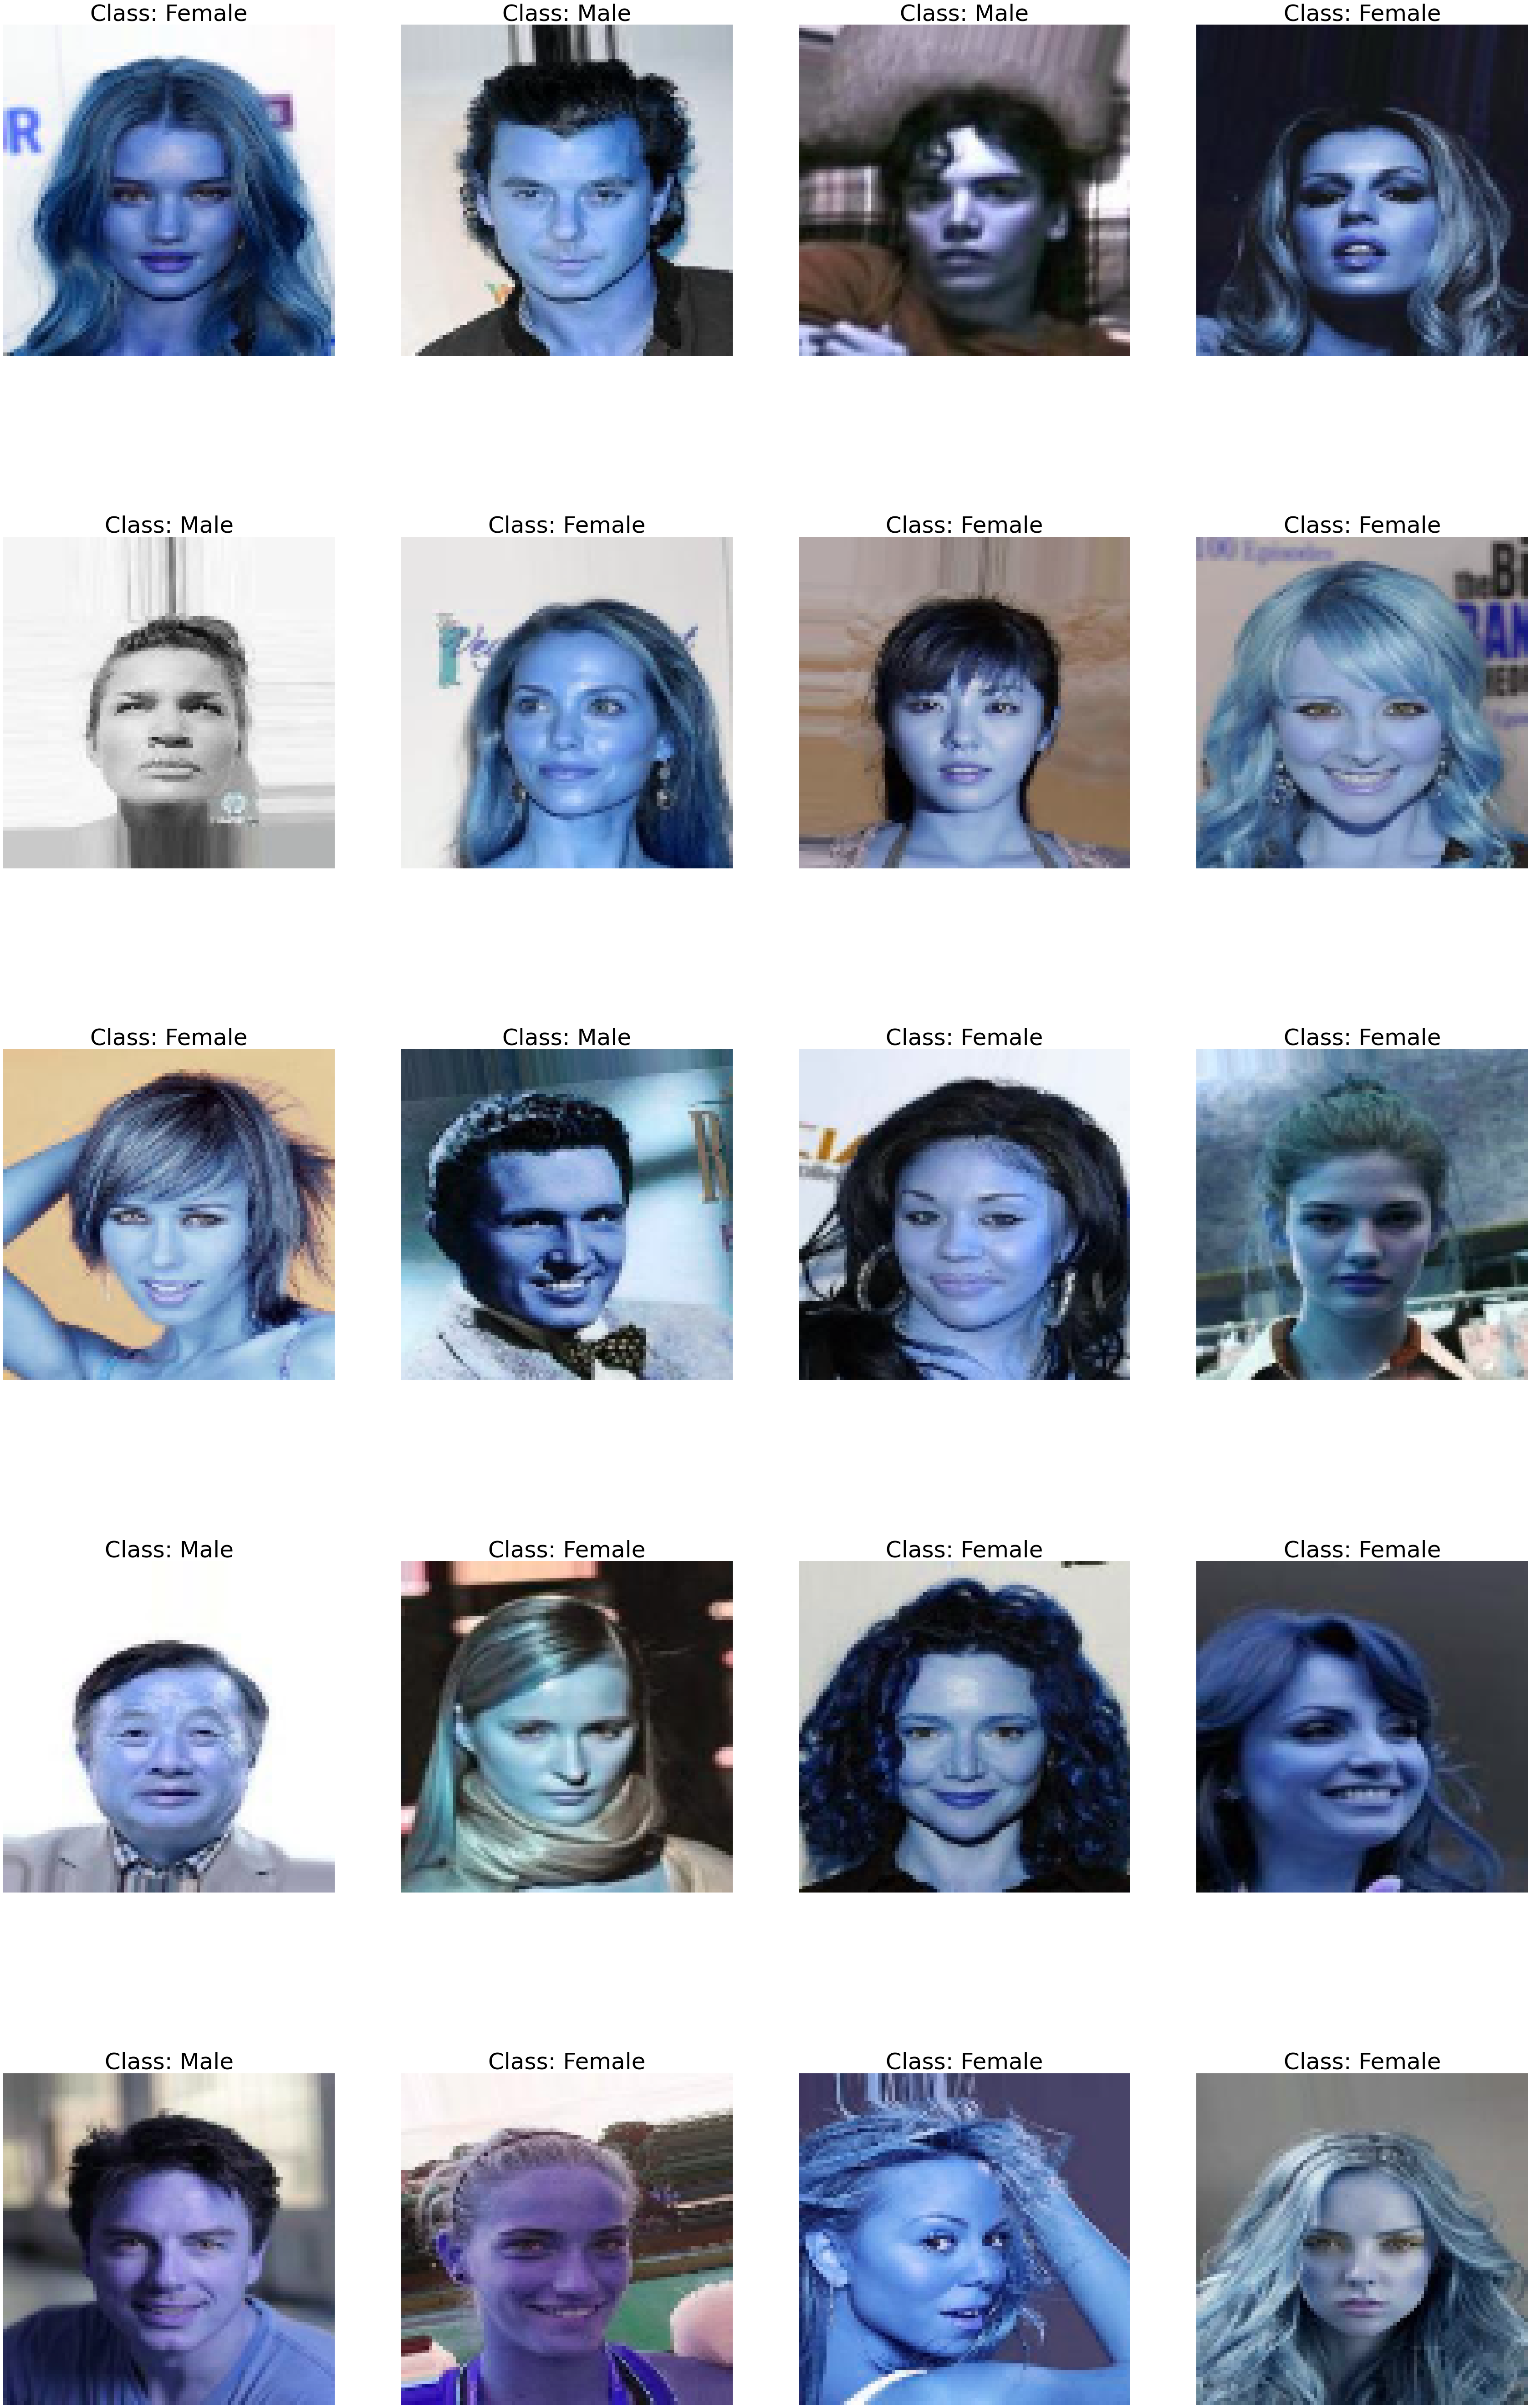

In [7]:
show_20_images(data,labels,20)

In [8]:
# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

In [9]:
# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

# build model
CelebA_model = SmallerVGGNet.build(width=img_dims[0], height=img_dims[1], depth=img_dims[2],
                            classes=2)

# compile the model
opt = Adam(lr=lr, decay=lr/epochs)
CelebA_model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the model
H = CelebA_model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, verbose=1)

# save the model to disk
CelebA_model.save("my_CelebA_model.h5")

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
250/250 [==============================] - 35s 141ms/step - loss: 0.5661 - accuracy: 0.7669 - val_loss: 0.6401 - val_accuracy: 0.6435
Epoch 2/100
250/250 [==============================] - 41s 163ms/step - loss: 0.3763 - accuracy: 0.8386 - val_loss: 0.3158 - val_accuracy: 0.8640
Epoch 3/100
250/250 [==============================] - 33s 131ms/step - loss: 0.2822 - accuracy: 0.8797 - val_loss: 0.1608 - val_accuracy: 0.9365
Epoch 4/100
250/250 [==============================] - 32s 130ms/step - loss: 0.2466 - accuracy: 0.8979 - val_loss: 0.1662 - val_accuracy: 0.9355
Epoch 5/100
250/250 [==============================] - 32s 129ms/step - loss: 0.2129 - accuracy: 0.9131 - val_loss: 0.2420 - val_accuracy: 0.9128
Epoch 6/100
250/250 [==============================] - 34s 135ms/step - loss: 0.2117 - accuracy: 0.9118 - val_loss: 0.1584 - val_accuracy: 0.9440
Epoch 7/100
250/250 [===========================

250/250 [==============================] - 32s 129ms/step - loss: 0.0852 - accuracy: 0.9671 - val_loss: 0.1686 - val_accuracy: 0.9430
Epoch 56/100
250/250 [==============================] - 32s 128ms/step - loss: 0.0839 - accuracy: 0.9682 - val_loss: 0.0759 - val_accuracy: 0.9725
Epoch 57/100
250/250 [==============================] - 32s 128ms/step - loss: 0.0778 - accuracy: 0.9709 - val_loss: 0.0919 - val_accuracy: 0.9650
Epoch 58/100
250/250 [==============================] - 32s 129ms/step - loss: 0.0800 - accuracy: 0.9699 - val_loss: 0.2031 - val_accuracy: 0.9280
Epoch 59/100
250/250 [==============================] - 32s 128ms/step - loss: 0.0891 - accuracy: 0.9657 - val_loss: 0.0946 - val_accuracy: 0.9653
Epoch 60/100
250/250 [==============================] - 32s 128ms/step - loss: 0.0825 - accuracy: 0.9676 - val_loss: 0.1089 - val_accuracy: 0.9595
Epoch 61/100
250/250 [==============================] - 32s 128ms/step - loss: 0.0837 - accuracy: 0.9686 - val_loss: 0.0886 - val_a

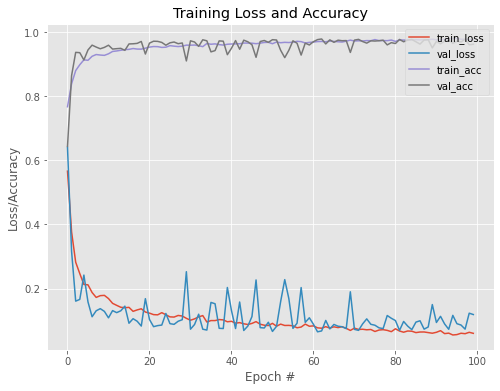

<Figure size 4320x7200 with 0 Axes>

In [10]:
# plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.show()
# save plot to disk
plt.savefig("my_figures")

## Training on Adience:

In [15]:
#Read label
df1 = pandas.read_table('label.txt', sep="\s+")
df1.columns = ['original_image', 'face_id', 'age_lower', 'age_higher', 'gender', 'x', 'y', 'dx', 'dy', 'tilt_ang', 'fiducial_yaw_angle', 'fiducial_score']
print(df1)

                            original_image  face_id age_lower age_higher  \
30601258@N03  10399646885_67c7d20df9_o.jpg        1      (25,        32)   
30601258@N03  10424815813_e94629b1ec_o.jpg        2      (25,        32)   
30601258@N03  10437979845_5985be4b26_o.jpg        1      (25,        32)   
30601258@N03  10437979845_5985be4b26_o.jpg        3      (25,        32)   
30601258@N03  11816644924_075c3d8d59_o.jpg        2      (25,        32)   
...                                    ...      ...       ...        ...   
7153718@N04   11598838386_349a0d4849_o.jpg     2282      None        596   
7153718@N04   11598166203_c70bb34c80_o.jpg     2283      None       1179   
7153718@N04   11598166203_c70bb34c80_o.jpg     2282      None       1201   
7153718@N04   11598145163_733cb99713_o.jpg     2282      None       1027   
7153718@N04   11598013005_240c2bc9c7_o.jpg     2282      None        498   

             gender     x     y    dx    dy  tilt_ang  fiducial_yaw_angle  \
30601258@N

In [16]:
data = []
labels = []
#load images
image_files2 = [f for f in glob.glob("aligned" + "/**/*", recursive=True) if not os.path.isdir(f)] 
random.seed(42)
random.shuffle(image_files2)
s=os.path.basename(image_files2[1])
print(s)
#Original_image is not unique, so we need both face_id and original_image 
parts = s.split(".")
face_id=parts[1]
original_image=parts[2]+'.'+parts[3]
print(original_image)
print(face_id)
#Remove entries that don't have gender 
df2=df1[df1.age_lower != 'None']
print(df2)
dflock_img=df2.loc[df2['original_image'] == original_image]
print(dflock_img)
dflock_img_id=dflock_img.loc[dflock_img['face_id'] == int(face_id)]
print(dflock_img_id)
print(dflock_img_id['age_lower'].to_string(index=False))
print(dflock_img_id['gender'].to_string(index=False))
print(dflock_img_id['gender'].to_string(index=False)==' m')

landmark_aligned_face.661.10044916713_9f5eb490bc_o.jpg
10044916713_9f5eb490bc_o.jpg
661
                             original_image  face_id age_lower age_higher  \
30601258@N03   10399646885_67c7d20df9_o.jpg        1      (25,        32)   
30601258@N03   10424815813_e94629b1ec_o.jpg        2      (25,        32)   
30601258@N03   10437979845_5985be4b26_o.jpg        1      (25,        32)   
30601258@N03   10437979845_5985be4b26_o.jpg        3      (25,        32)   
30601258@N03   11816644924_075c3d8d59_o.jpg        2      (25,        32)   
...                                     ...      ...       ...        ...   
101515718@N03  10587826073_6663f5b654_o.jpg     2280      (25,        32)   
101515718@N03  10587571495_a61785cd06_o.jpg     2278      (25,        32)   
101515718@N03  10587571495_a61785cd06_o.jpg     2279      (25,        32)   
50458575@N08    9426695459_9e8b347604_o.jpg     2281      (25,        32)   
50458575@N08    9429464468_1bfc39ecfb_o.jpg     2281      (25,   

In [ ]:
# create groud-truth label from the image path
for img in image_files2:
    s=os.path.basename(img)
    parts = s.split(".")
    face_id=parts[1]
    original_image=parts[2]+'.'+parts[3]
    dflock_img=df2.loc[df2['original_image'] == original_image]
    dflock_img_id=dflock_img.loc[dflock_img['face_id'] == int(face_id)]
    if dflock_img_id.empty:
        continue
    else:
        image = cv2.imread(img)
        image = cv2.resize(image, (img_dims[0],img_dims[1]))
        image = img_to_array(image)
        data.append(image)
        if dflock_img_id['gender'].to_string(index=False)==" f":
            label = 1
        else:
            label = 0
        labels.append([label])


In [18]:
# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
#generate_h5_data(data,labels,"I_LUV_U")   

The keys are:  KeysView(<HDF5 file "I_LUV_U.h5" (mode r)>)
The shape of x_field (18622, 96, 96, 3)
The shape of y_field (18622, 1)
x_data shape: (18622, 96, 96, 3)
x_data shape: (18622, 1)


The keys are:  <KeysViewHDF5 ['image', 'label']>
The shape of x_field (18622, 96, 96, 3)
The shape of y_field (18622, 1)
(18622, 96, 96, 3)


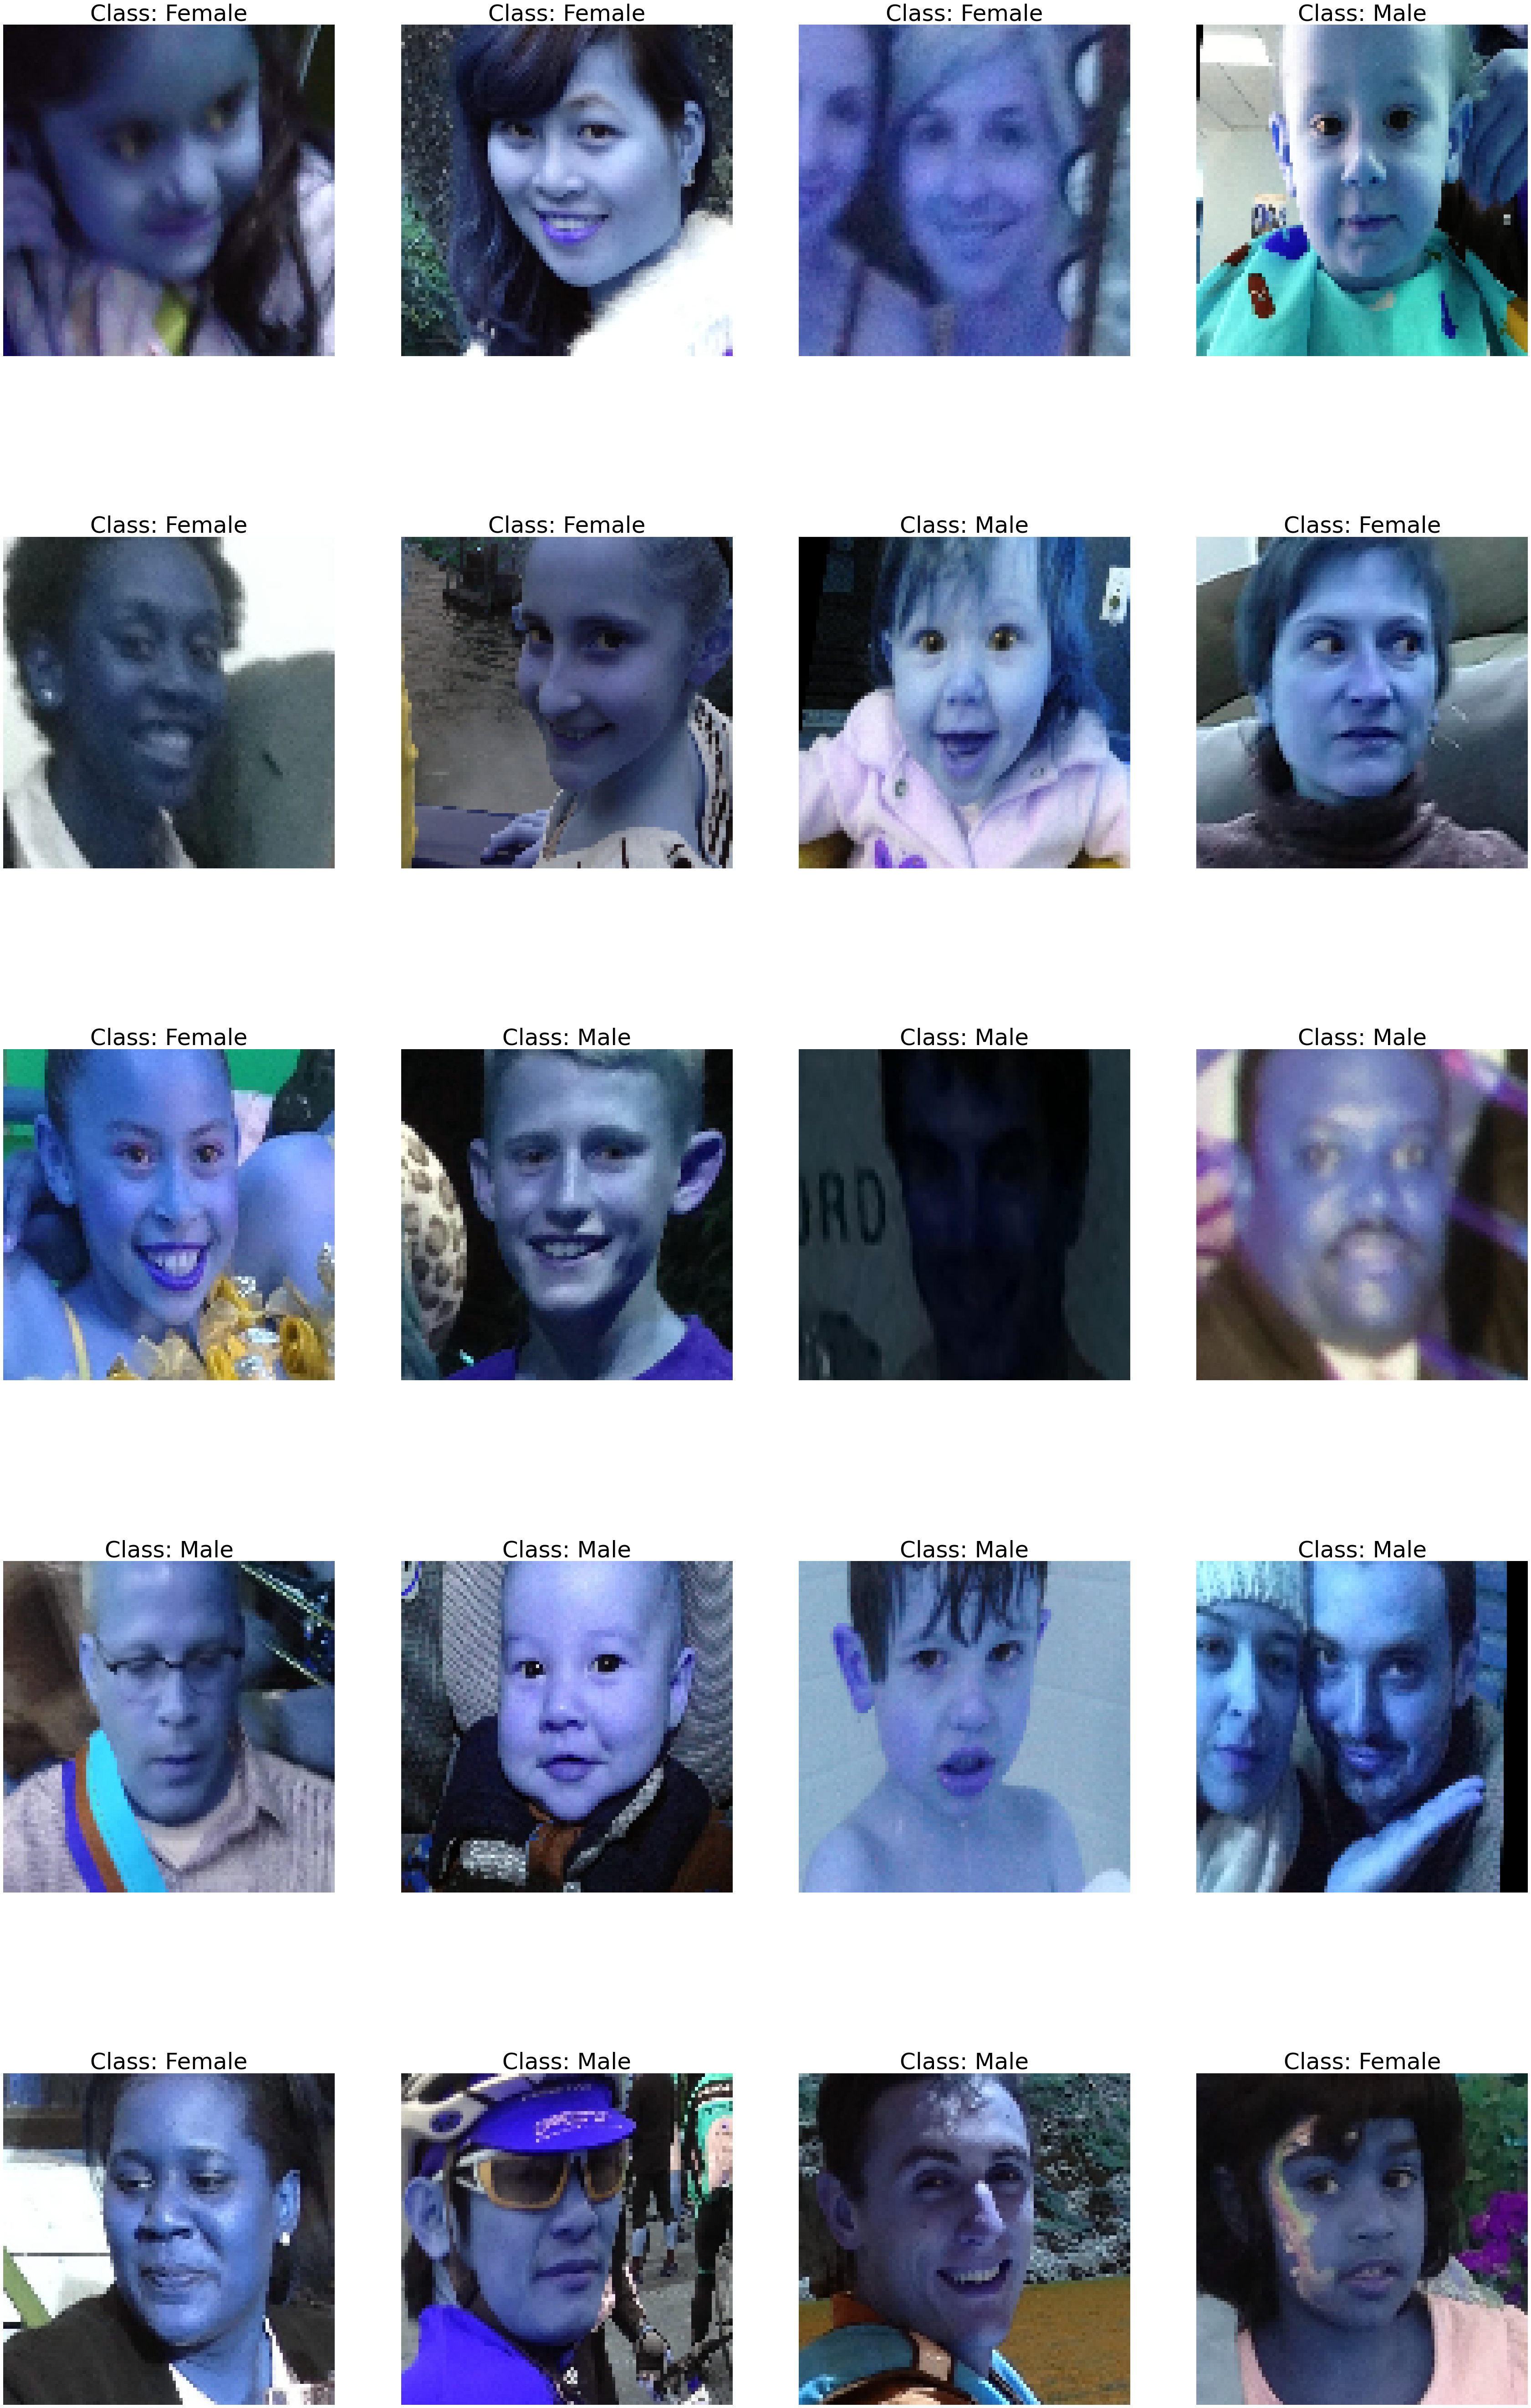

In [14]:
#Can skip the above data prep and run this to save time 
#data,labels=load_h5_data("I_LUV_U.h5")
show_20_images(data,labels,20)

In [12]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)


## Building Adience Model for freezing layers:

In [13]:
# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

# build model
Adience_model = tf.keras.models.load_model("my_CelebA_model.h5")


In [14]:
Adience_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0

The summary allows us to recognise what layers contain parameters that might be trainable

### Freeze then compile model:

In [15]:
#Freeze model
Adience_model.trainable = False

# compile the model, need to reduce lr to reduce overfit
opt = Adam(lr=lr, decay=lr/epochs)
Adience_model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


### Unfreeze top 6 layers then compile model:

In [16]:
Adience_model.trainable = True
print("weights:", len(Adience_model.weights))
print("trainable_weights:", len(Adience_model.trainable_weights))
print("non_trainable_weights:", len(Adience_model.non_trainable_weights))
len(Adience_model.trainable_variables)


weights: 38
trainable_weights: 26
non_trainable_weights: 12


26

In [17]:
print("Number of layers in the base model: ", len(Adience_model.layers))

Number of layers in the base model:  28


In [18]:
# Fine-tune from this layer onwards
fine_tune_at = 22

# Freeze all the layers before the `fine_tune_at` layer
for layer in Adience_model.layers[:fine_tune_at]:
    layer.trainable =  False

layers = [(layer, layer.name, layer.trainable) for layer in Adience_model.layers]
pandas.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

Layer Type             Layer Name  \
0   <tensorflow.python.keras.layers.convolutional....                 conv2d   
1   <tensorflow.python.keras.layers.core.Activatio...             activation   
2   <tensorflow.python.keras.layers.normalization_...    batch_normalization   
3   <tensorflow.python.keras.layers.pooling.MaxPoo...          max_pooling2d   
4   <tensorflow.python.keras.layers.core.Dropout o...                dropout   
5   <tensorflow.python.keras.layers.convolutional....               conv2d_1   
6   <tensorflow.python.keras.layers.core.Activatio...           activation_1   
7   <tensorflow.python.keras.layers.normalization_...  batch_normalization_1   
8   <tensorflow.python.keras.layers.convolutional....               conv2d_2   
9   <tensorflow.python.keras.layers.core.Activatio...           activation_2   
10  <tensorflow.python.keras.layers.normalization_...  batch_normalization_2   
11  <tensorflow.python.keras.layers.pooling.MaxPoo...        max_pooling2d_1   
12  <tensorflow.python.keras.layers.core.Dropout o...              dropout_1   
13  <tensorflow.python.keras.layers.convolutional....               conv2d_3   
14  <tensorflow.python.keras.layers.core.Activatio...           activation_3   
15  <tensorflow.python.keras.layers.normalization_...  batch_normalization_3   
16  <tensorflow.python.keras.layers.convolutional....               conv2d_4   
17  <tensorflow.python.keras.layers.core.Activatio...           activation_4   
18  <tensorflow.python.keras.layers.normalization_...  batch_normalization_4   
19  <tensorflow.python.keras.layers.pooling.MaxPoo...        max_pooling2d_2   
20  <tensorflow.python.keras.layers.core.Dropout o...              dropout_2   
21  <tensorflow.python.keras.layers.core.Flatten o...                flatten   
22  <tensorflow.python.keras.layers.core.Dense obj...                  dense   
23  <tensorflow.python.keras.layers.core.Activatio...           activation_5   
24  <tensorflow.python.keras.layers.normalization_...  batch_normalization_5   
25  <tensorflow.python.keras.layers.core.Dropout o...              dropout_3   
26  <tensorflow.python.keras.layers.core.Dense obj...                dense_1   
27  <tensorflow.python.keras.layers.core.Activatio...           activation_6   

    Layer Trainable  
0             False  
1             False  
2             False  
3             False  
4             False  
5             False  
6             False  
7             False  
8             False  
9             False  
10            False  
11            False  
12            False  
13            False  
14            False  
15            False  
16            False  
17            False  
18            False  
19            False  
20            False  
21            False  
22             True  
23             True  
24             True  
25             True  
26             True  
27             True

In [19]:
# compile the model
opt = Adam(lr=lr, decay=lr/epochs)
Adience_model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [20]:
Adience_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0

Now we can see that dense_2, batch_normalization_11 and dense_3 paramets are trainable.

## Train Adience Model with fixed trainable parameters:

Epochs have to increase to see the effect of fine-tuning.

In [21]:
# train the model
H_tune = Adience_model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs+90, verbose=1)




Epoch 1/190
232/232 [==============================] - 30s 131ms/step - loss: 0.6691 - accuracy: 0.7123 - val_loss: 0.4564 - val_accuracy: 0.7911
Epoch 2/190
232/232 [==============================] - 30s 128ms/step - loss: 0.5023 - accuracy: 0.7588 - val_loss: 0.4219 - val_accuracy: 0.8150
Epoch 3/190
232/232 [==============================] - 30s 128ms/step - loss: 0.4800 - accuracy: 0.7761 - val_loss: 0.4213 - val_accuracy: 0.8134
Epoch 4/190
232/232 [==============================] - 29s 126ms/step - loss: 0.4698 - accuracy: 0.7798 - val_loss: 0.4111 - val_accuracy: 0.8212
Epoch 5/190
232/232 [==============================] - 30s 128ms/step - loss: 0.4645 - accuracy: 0.7828 - val_loss: 0.4251 - val_accuracy: 0.8115
Epoch 6/190
232/232 [==============================] - 29s 127ms/step - loss: 0.4635 - accuracy: 0.7860 - val_loss: 0.4059 - val_accuracy: 0.8185
Epoch 7/190
232/232 [==============================] - 29s 127ms/step - loss: 0.4529 - accuracy: 0.7904 - val_loss: 0.4009 -

Epoch 57/190
232/232 [==============================] - 29s 126ms/step - loss: 0.3569 - accuracy: 0.8434 - val_loss: 0.3372 - val_accuracy: 0.8566
Epoch 58/190
232/232 [==============================] - 29s 127ms/step - loss: 0.3635 - accuracy: 0.8377 - val_loss: 0.3290 - val_accuracy: 0.8650
Epoch 59/190
232/232 [==============================] - 29s 126ms/step - loss: 0.3640 - accuracy: 0.8393 - val_loss: 0.3321 - val_accuracy: 0.8596
Epoch 60/190
232/232 [==============================] - 29s 126ms/step - loss: 0.3534 - accuracy: 0.8459 - val_loss: 0.3270 - val_accuracy: 0.8628
Epoch 61/190
232/232 [==============================] - 29s 127ms/step - loss: 0.3601 - accuracy: 0.8403 - val_loss: 0.3396 - val_accuracy: 0.8577
Epoch 62/190
232/232 [==============================] - 29s 127ms/step - loss: 0.3575 - accuracy: 0.8426 - val_loss: 0.3341 - val_accuracy: 0.8572
Epoch 63/190
232/232 [==============================] - 29s 127ms/step - loss: 0.3643 - accuracy: 0.8426 - val_loss: 0

232/232 [==============================] - 30s 128ms/step - loss: 0.3044 - accuracy: 0.8677 - val_loss: 0.3055 - val_accuracy: 0.8795
Epoch 168/190
232/232 [==============================] - 29s 126ms/step - loss: 0.3017 - accuracy: 0.8745 - val_loss: 0.3092 - val_accuracy: 0.8784
Epoch 169/190
232/232 [==============================] - 29s 126ms/step - loss: 0.3080 - accuracy: 0.8682 - val_loss: 0.3074 - val_accuracy: 0.8765
Epoch 170/190
232/232 [==============================] - 29s 126ms/step - loss: 0.2988 - accuracy: 0.8716 - val_loss: 0.3056 - val_accuracy: 0.8752
Epoch 171/190
232/232 [==============================] - 29s 127ms/step - loss: 0.3085 - accuracy: 0.8696 - val_loss: 0.3046 - val_accuracy: 0.8749
Epoch 172/190
232/232 [==============================] - 29s 126ms/step - loss: 0.3053 - accuracy: 0.8685 - val_loss: 0.3082 - val_accuracy: 0.8765
Epoch 173/190
232/232 [==============================] - 29s 127ms/step - loss: 0.2958 - accuracy: 0.8759 - val_loss: 0.3055 -

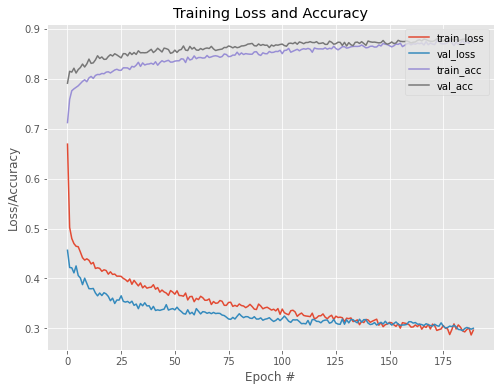

<Figure size 4320x7200 with 0 Axes>

In [23]:
# plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
N = epochs+90
plt.plot(np.arange(0,N), H_tune.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H_tune.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H_tune.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H_tune.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.show()
# save plot to disk
plt.savefig("my_figures1")

In [24]:
Adience_model.save("Adience_model_fine.h5")

# VGG19

In [6]:
data,labels=load_h5_data("I_LUV_U.h5")

The keys are:  <KeysViewHDF5 ['image', 'label']>
The shape of x_field (18622, 96, 96, 3)
The shape of y_field (18622, 1)


(18622, 96, 96, 3)


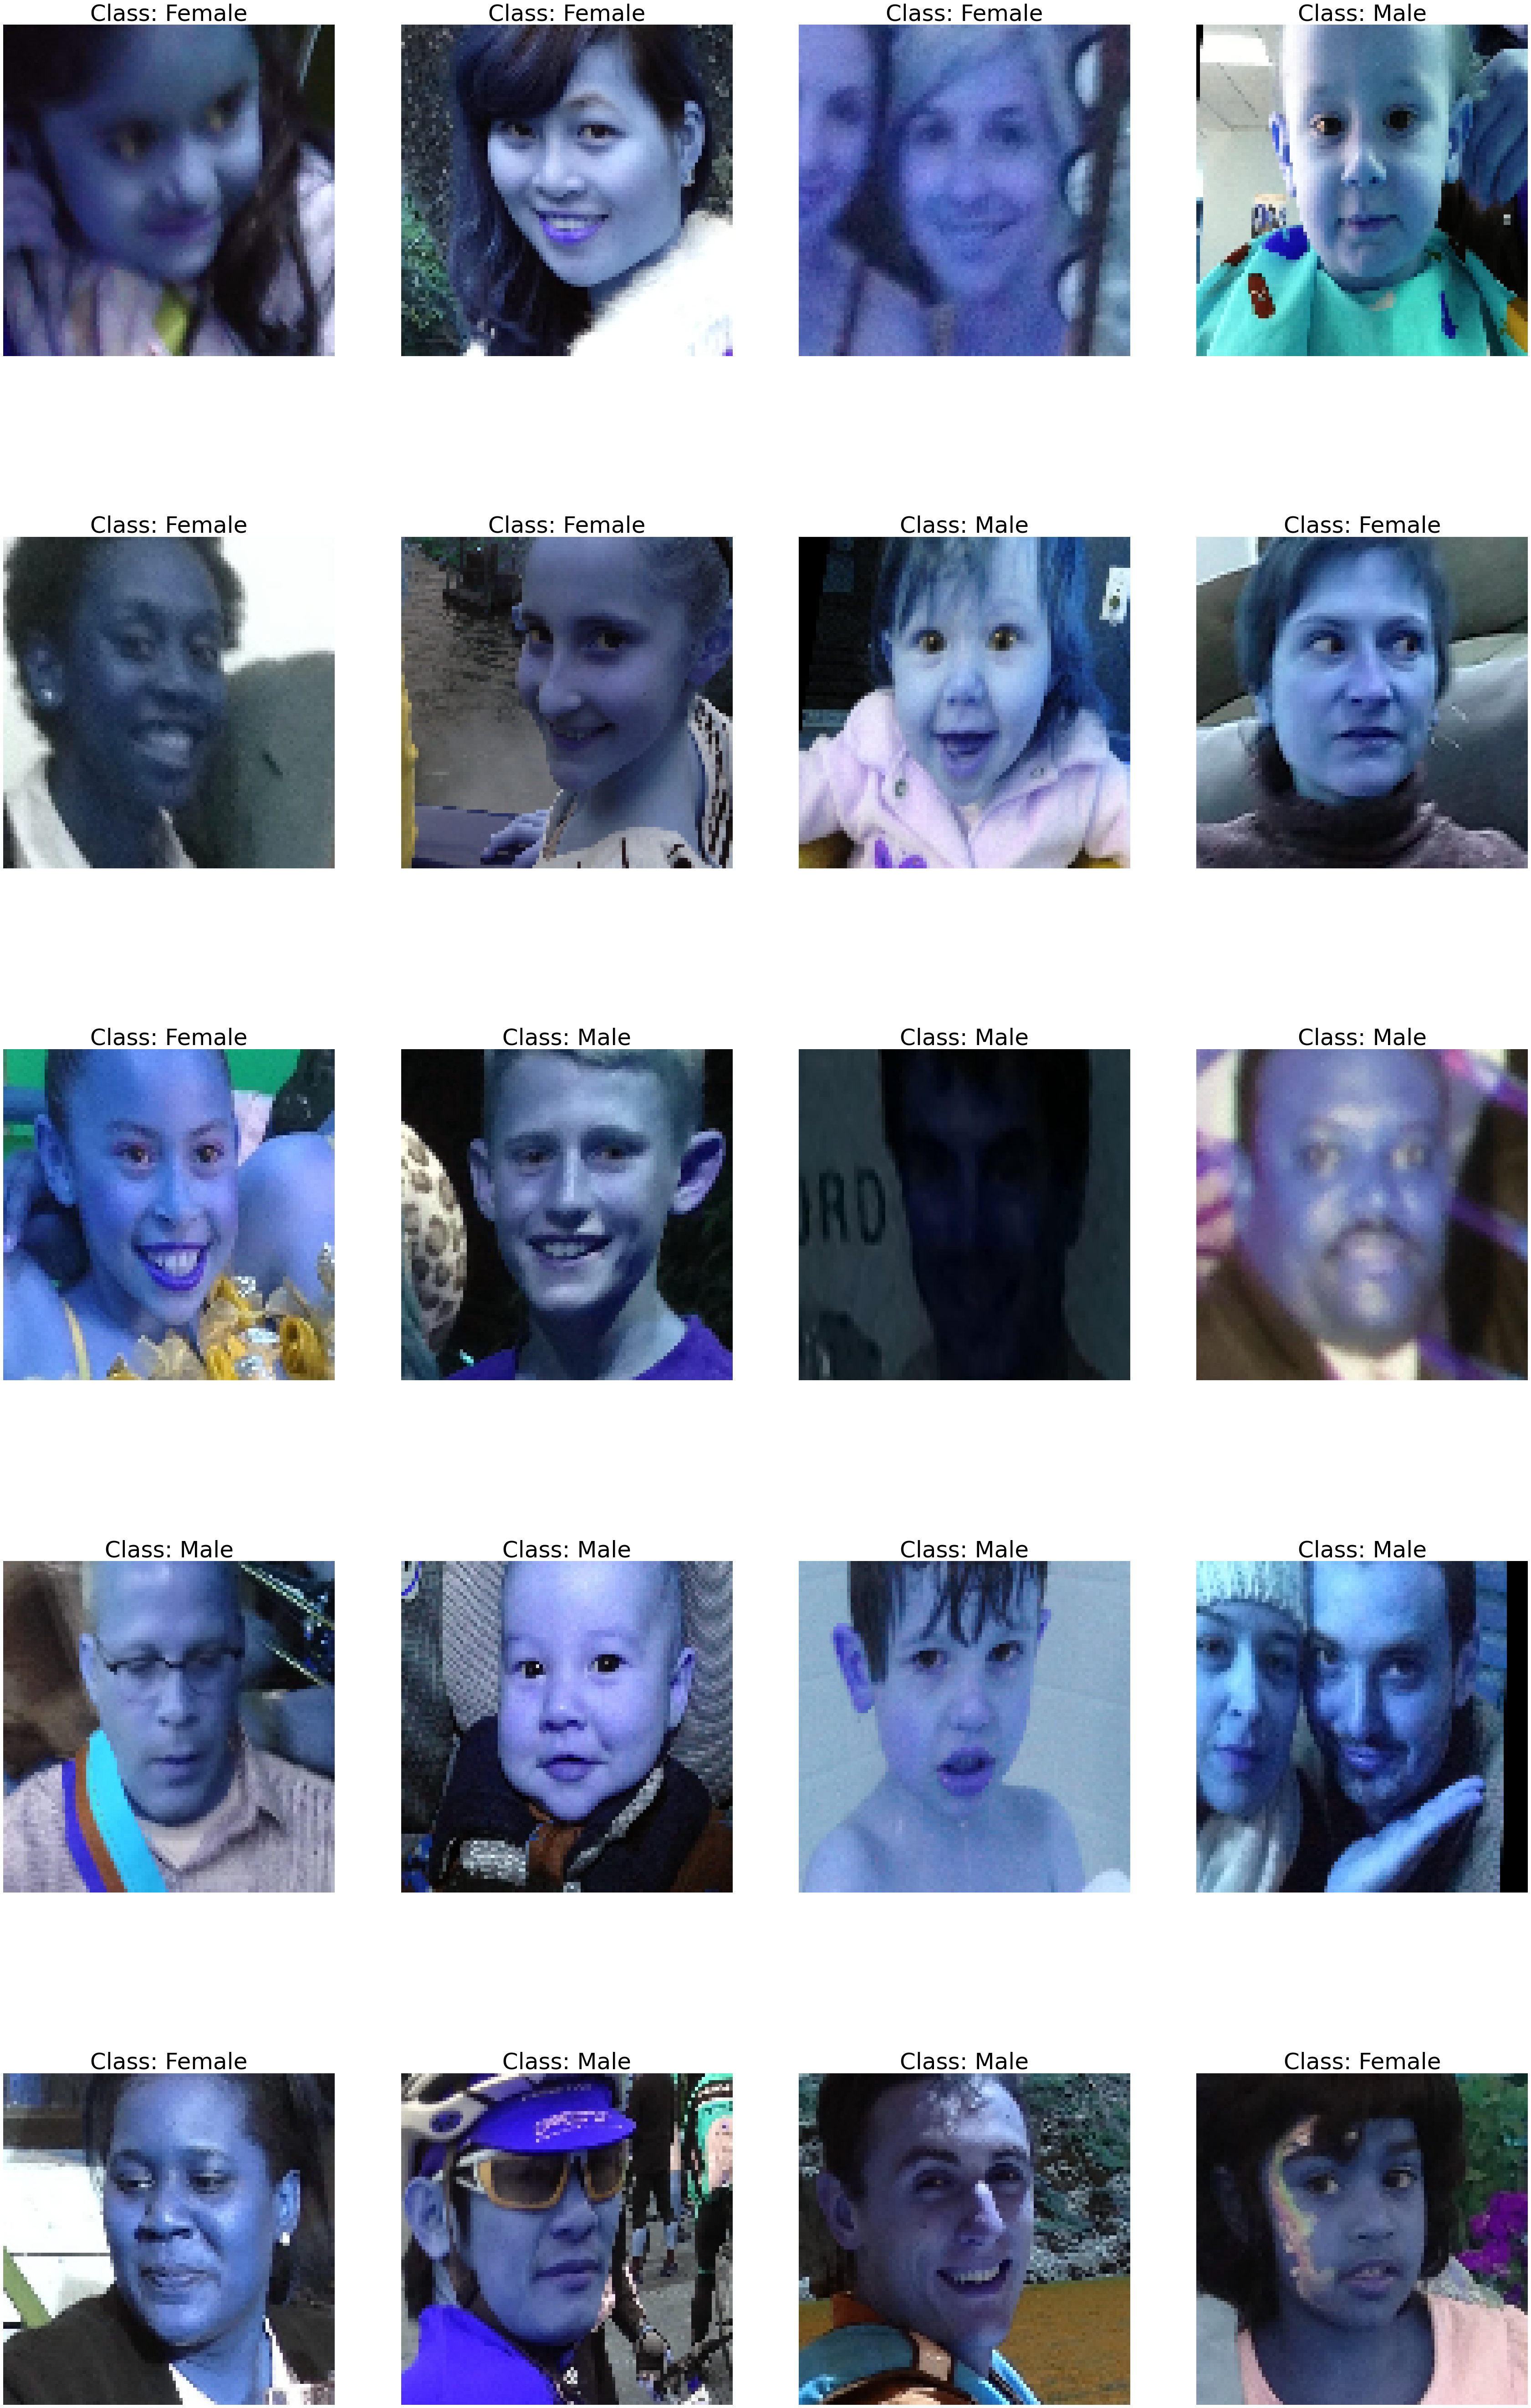

In [7]:
show_20_images(data,labels,20)

In [8]:
new_label = [i[0] for i in labels]
new_label = np.array(new_label)
print(new_label)

[1 0 1 ... 0 0 0]


In [9]:
perm = np.random.permutation(data.shape[0])
data = data[perm]
new_label = new_label[perm]

In [10]:
vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

In [11]:
vgg19.trainable=False

In [12]:
model_2=tf.keras.Sequential([
    vgg19, tf.keras.layers.GlobalAveragePooling2D(), tf.keras.layers.Dense(1)
])

In [13]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 20,024,897
Trainable params: 513
Non-trainable params: 20,024,384
_________________________________________________________________


In [14]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

Epoch 1/100
233/233 [==============================] - 20s 87ms/step - loss: 0.7493 - accuracy: 0.5948 - val_loss: 0.7187 - val_accuracy: 0.6040
Epoch 2/100
233/233 [==============================] - 19s 82ms/step - loss: 0.6920 - accuracy: 0.6125 - val_loss: 0.6850 - val_accuracy: 0.6126
Epoch 3/100
233/233 [==============================] - 19s 83ms/step - loss: 0.6862 - accuracy: 0.6118 - val_loss: 0.7670 - val_accuracy: 0.5646
Epoch 4/100
233/233 [==============================] - 19s 83ms/step - loss: 0.6854 - accuracy: 0.6092 - val_loss: 0.6632 - val_accuracy: 0.6137
Epoch 5/100
233/233 [==============================] - 20s 87ms/step - loss: 0.6560 - accuracy: 0.6267 - val_loss: 0.6608 - val_accuracy: 0.6183
Epoch 6/100
233/233 [==============================] - 19s 83ms/step - loss: 0.6532 - accuracy: 0.6319 - val_loss: 0.6611 - val_accuracy: 0.6199
Epoch 7/100
233/233 [==============================] - 19s 83ms/step - loss: 0.6499 - accuracy: 0.6366 - val_loss: 0.6562 - val_ac

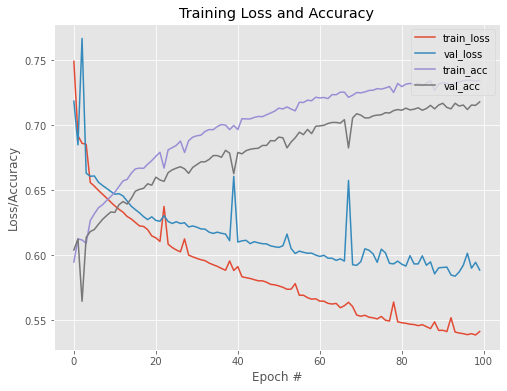

<Figure size 4320x7200 with 0 Axes>

In [15]:
# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

# compile the model, need to reduce lr to reduce overfit
#opt = Adam(lr=lr, decay=lr/epochs)
model_2.compile(
    optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr/10, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=(lr/10)/epochs, amsgrad=False,
    name='Adam'
    ),
    loss=tf.keras.losses.BinaryCrossentropy(
    ),
    metrics=['accuracy'])
# train the model
H=model_2.fit(data,new_label, epochs=epochs,batch_size = batch_size,validation_split = 0.2      )
# save the model to disk
model_2.save("my_model3")

# plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.show()
# save plot to disk
plt.savefig("my_figures3")


# MobileNet V2

In [6]:
data,labels=load_h5_data("I_LUV_U.h5")

The keys are:  <KeysViewHDF5 ['image', 'label']>
The shape of x_field (18622, 96, 96, 3)
The shape of y_field (18622, 1)


(18622, 96, 96, 3)


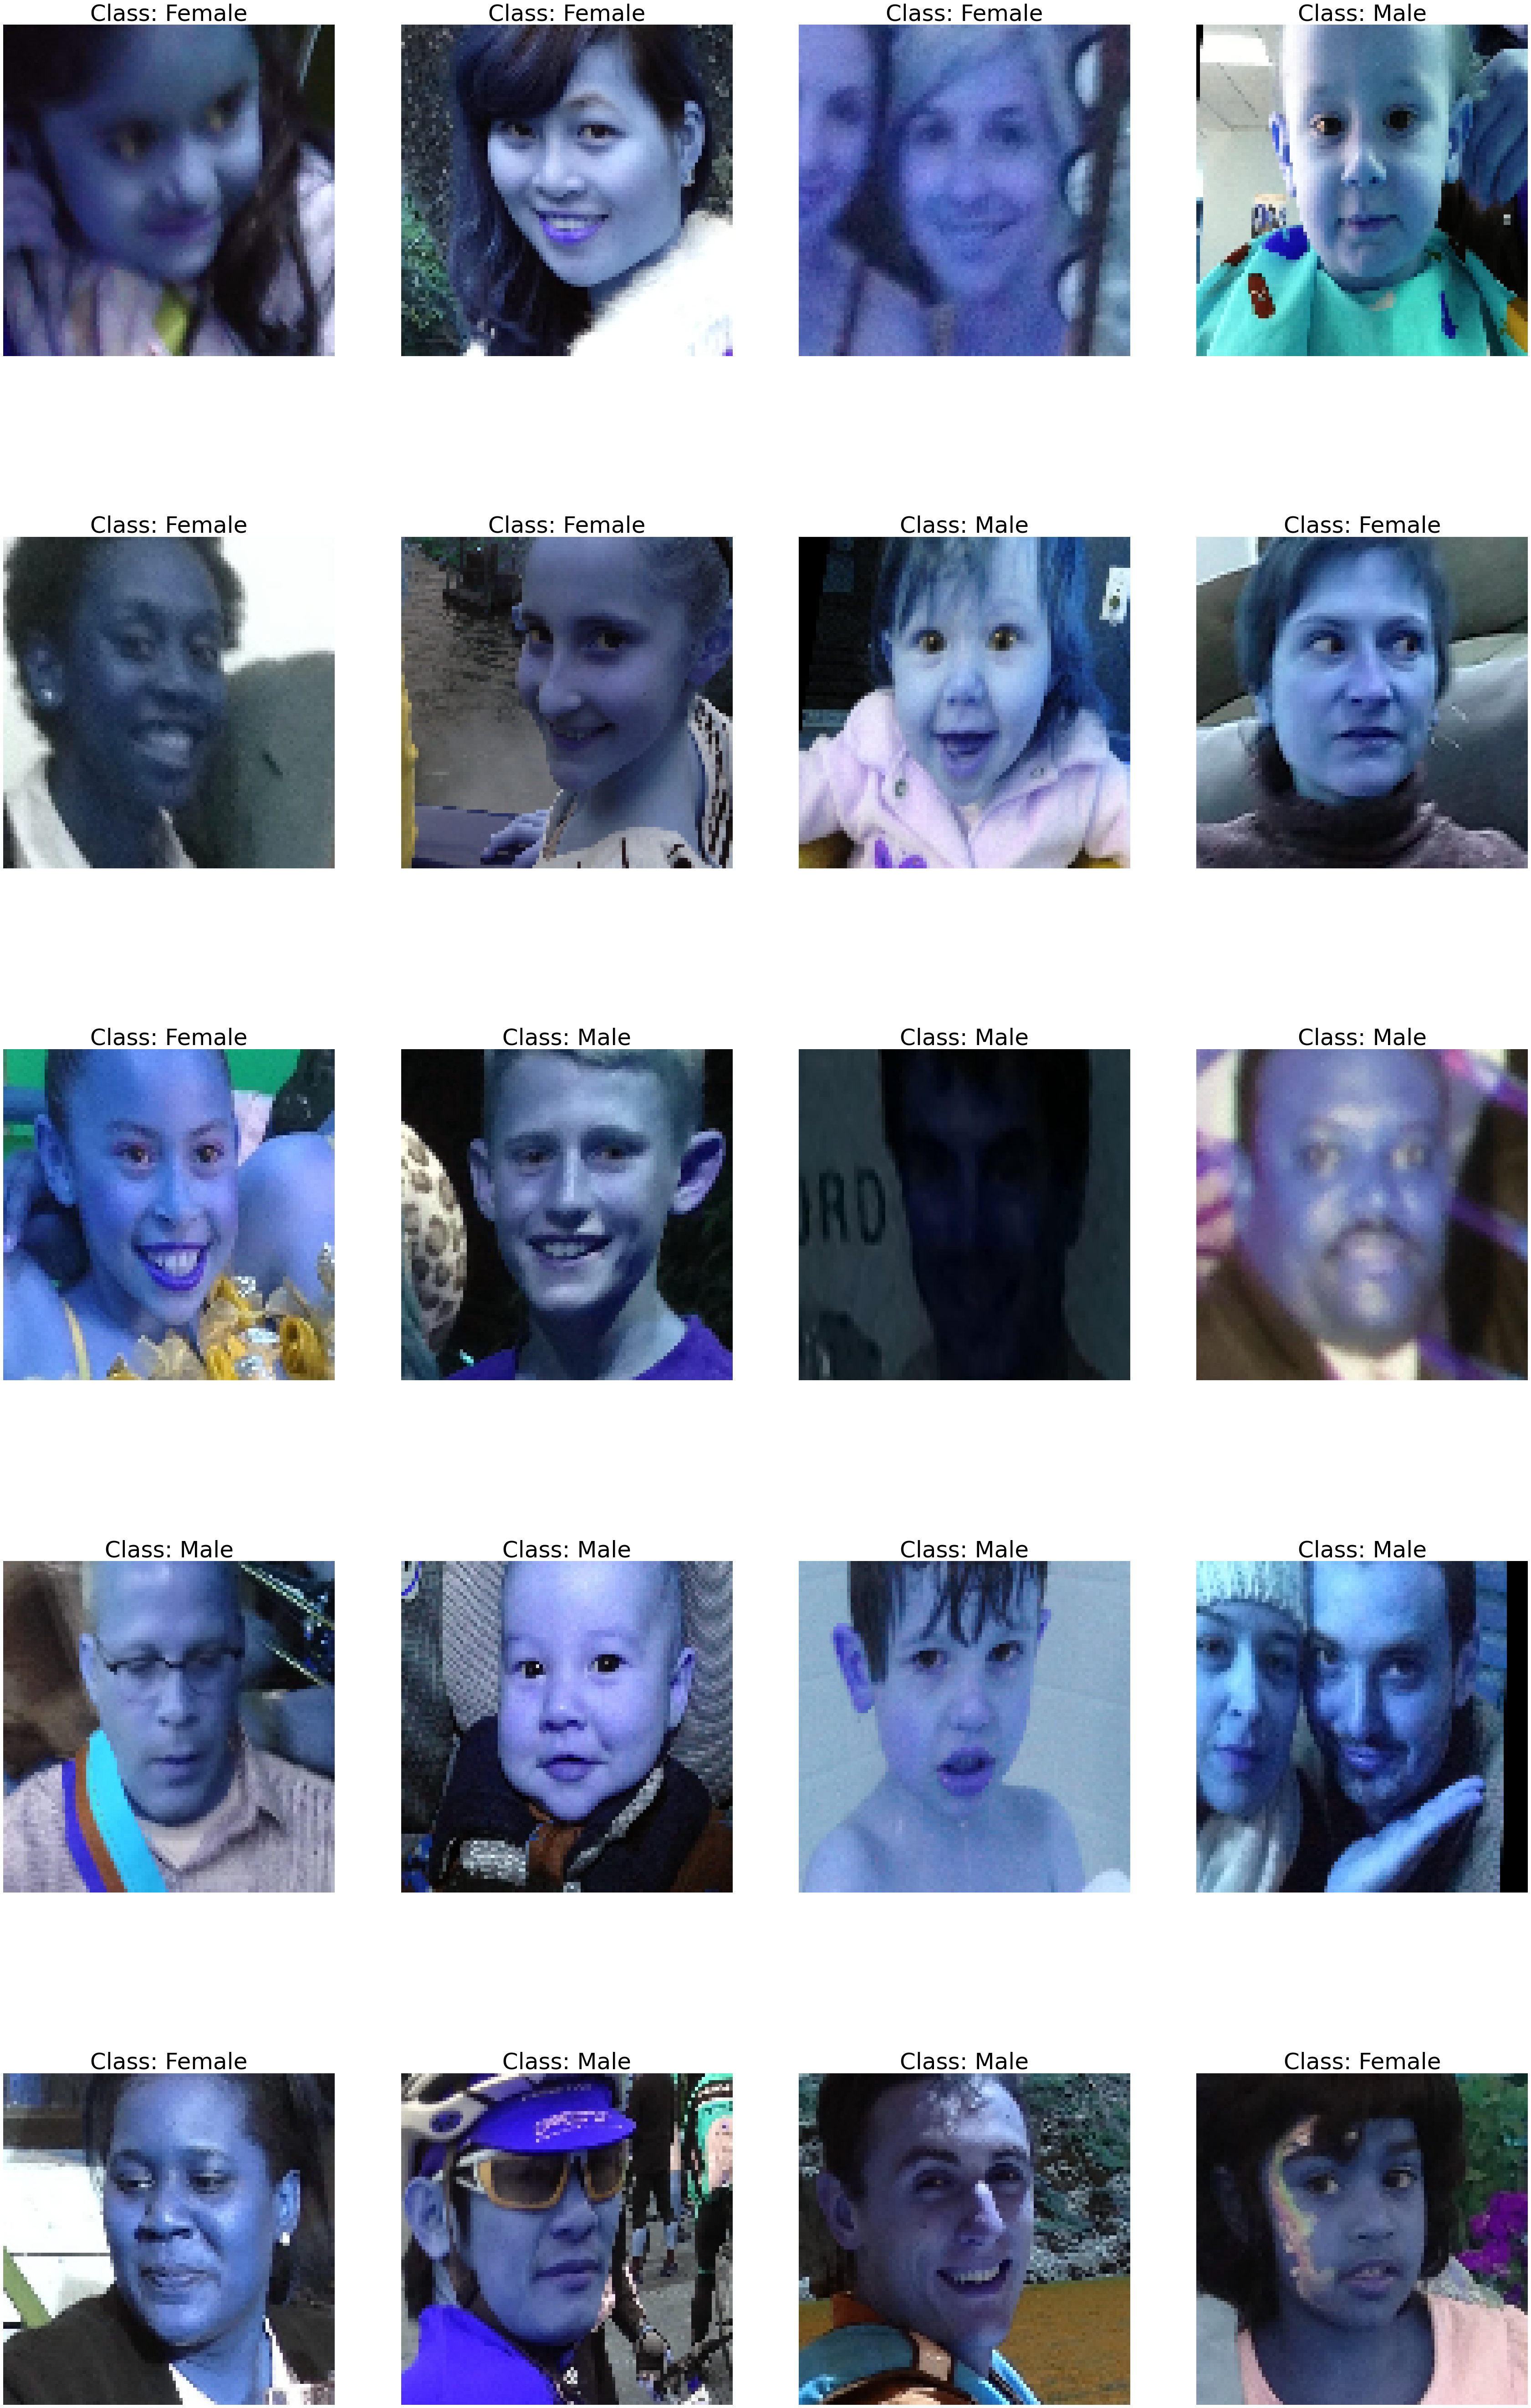

In [7]:
show_20_images(data,labels,20)

In [8]:
new_label = [i[0] for i in labels]
new_label = np.array(new_label)
print(new_label)

[1 0 1 ... 0 0 0]


In [9]:
perm = np.random.permutation(data.shape[0])
data = data[perm]
new_label = new_label[perm]
subset = 1024
trainX = data[:subset]
trainY = labels[:subset]

In [10]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(96,96,3),
                                               include_top=False,
                                               weights='imagenet')

In [11]:
mobile_net.trainable=False

In [12]:
model_3=tf.keras.Sequential([
    mobile_net, tf.keras.layers.GlobalAveragePooling2D(), tf.keras.layers.Dense(1)
])

In [13]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
mobile_net.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

Epoch 1/100
233/233 [==============================] - 8s 35ms/step - loss: 3.6636 - accuracy: 0.6032 - val_loss: 3.4491 - val_accuracy: 0.6118
Epoch 2/100
233/233 [==============================] - 7s 30ms/step - loss: 3.4077 - accuracy: 0.6238 - val_loss: 3.3162 - val_accuracy: 0.6274
Epoch 3/100
233/233 [==============================] - 7s 31ms/step - loss: 3.2818 - accuracy: 0.6307 - val_loss: 3.2745 - val_accuracy: 0.6352
Epoch 4/100
233/233 [==============================] - 7s 32ms/step - loss: 3.2137 - accuracy: 0.6446 - val_loss: 3.1568 - val_accuracy: 0.6430
Epoch 5/100
233/233 [==============================] - 7s 30ms/step - loss: 3.1661 - accuracy: 0.6483 - val_loss: 3.1094 - val_accuracy: 0.6403
Epoch 6/100
233/233 [==============================] - 8s 34ms/step - loss: 3.2452 - accuracy: 0.6487 - val_loss: 3.0977 - val_accuracy: 0.6507
Epoch 7/100
233/233 [==============================] - 7s 31ms/step - loss: 3.0184 - accuracy: 0.6482 - val_loss: 2.9638 - val_accuracy:

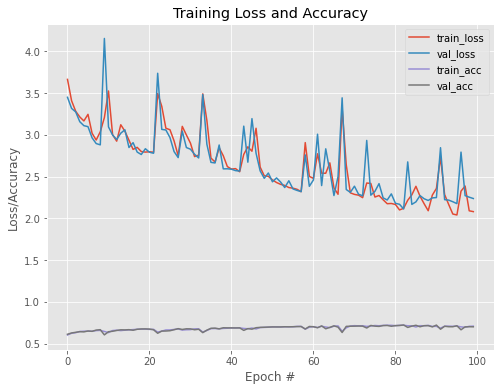

<Figure size 4320x7200 with 0 Axes>

In [15]:
# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

# compile the model, need to reduce lr to reduce overfit
#opt = Adam(lr=lr, decay=lr/epochs)
model_3.compile(
    optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr/10, beta_1=0.9, beta_2=0.999, epsilon=1e-07,decay=(lr/10)/epochs, amsgrad=False,
    name='Adam'
    ),
    loss=tf.keras.losses.BinaryCrossentropy(
    ),
    metrics=['accuracy'])
# train the model
H=model_3.fit(data,new_label, epochs=epochs,batch_size = batch_size,validation_split = 0.2      )
# save the model to disk
model_3.save("my_model4")

# plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.show()
# save plot to disk
plt.savefig("my_figures4")


# ResNet50

In [6]:
data,labels=load_h5_data("I_LUV_U.h5")

The keys are:  <KeysViewHDF5 ['image', 'label']>
The shape of x_field (18622, 96, 96, 3)
The shape of y_field (18622, 1)


(18622, 96, 96, 3)


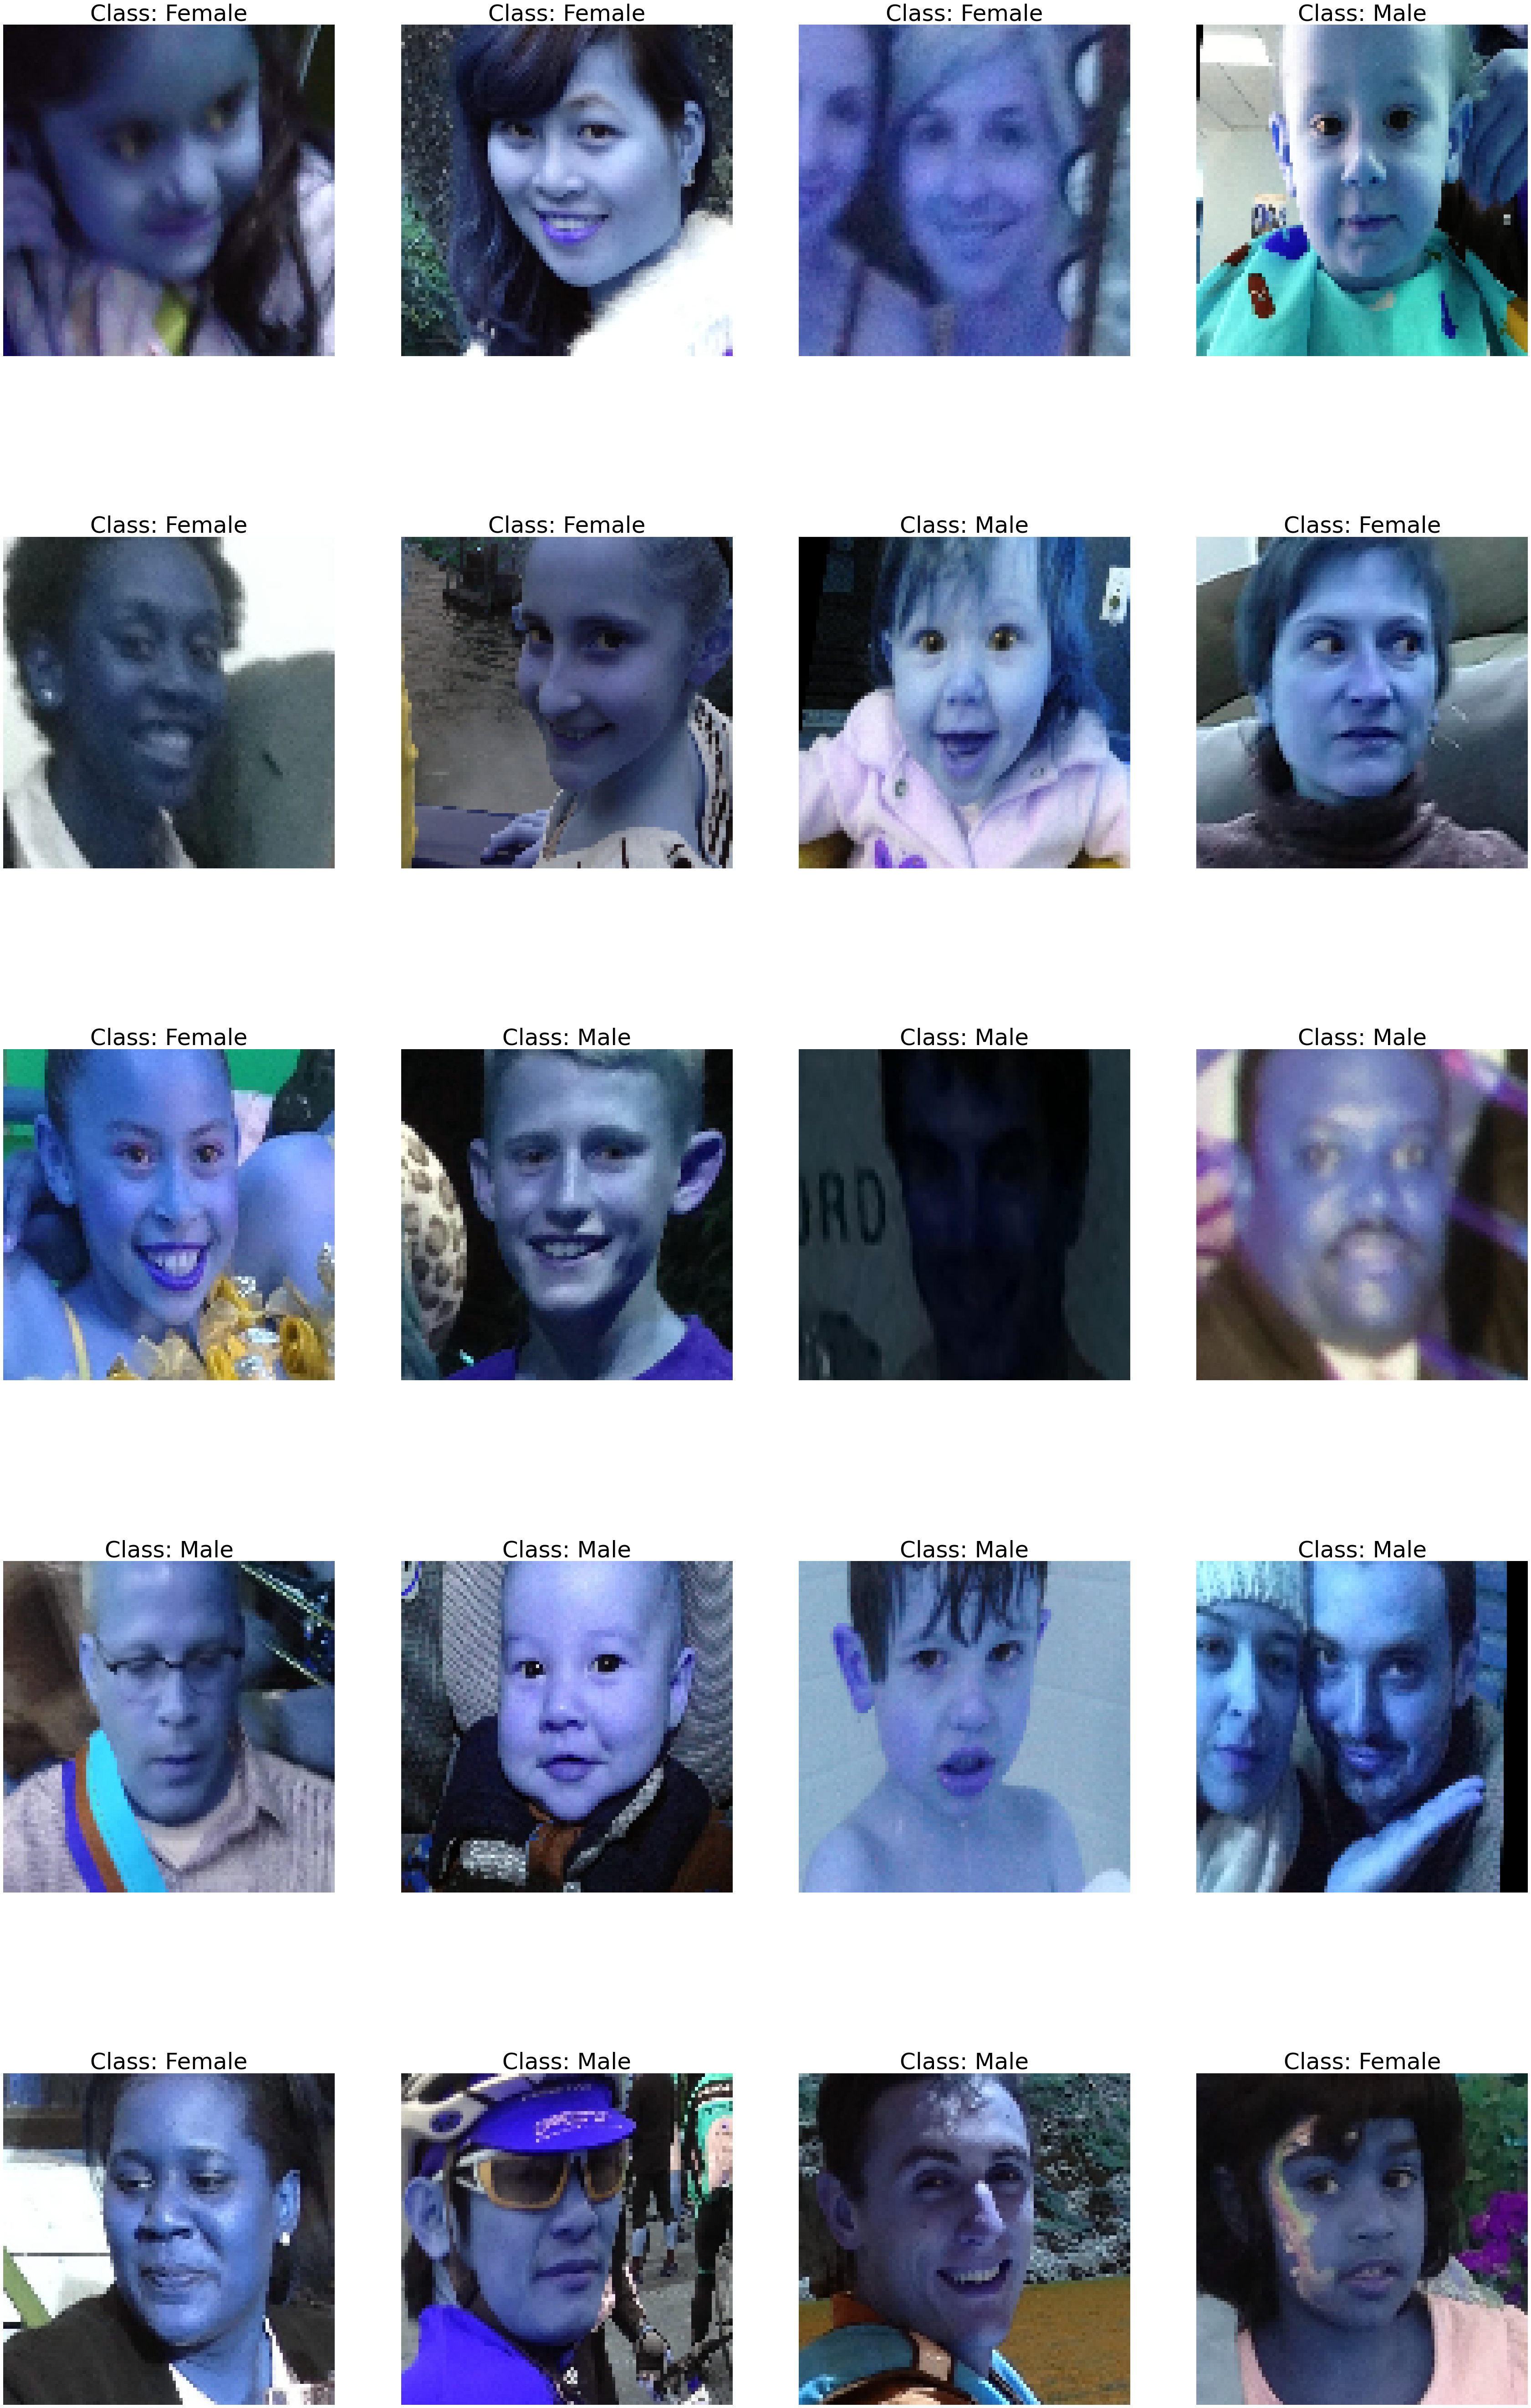

In [7]:
show_20_images(data,labels,20)

In [8]:
new_label = [i[0] for i in labels]
new_label = np.array(new_label)
print(new_label)

[1 0 1 ... 0 0 0]


In [9]:
perm = np.random.permutation(data.shape[0])
data = data[perm]
new_label = new_label[perm]
subset = 1024
trainX = data[:subset]
trainY = labels[:subset]

In [10]:
resnet_net = tf.keras.applications.ResNet50(input_shape=(96,96,3),
                                               include_top=False,
                                               weights='imagenet')

In [11]:
resnet_net.trainable=False

In [12]:
model_4=tf.keras.Sequential([
    resnet_net, tf.keras.layers.GlobalAveragePooling2D(), tf.keras.layers.Dense(1)
])

In [13]:
model_4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [14]:
resnet_net.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 48, 48, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Epoch 1/100
233/233 [==============================] - 16s 68ms/step - loss: 0.8127 - accuracy: 0.5376 - val_loss: 0.7082 - val_accuracy: 0.5267
Epoch 2/100
233/233 [==============================] - 14s 61ms/step - loss: 0.7012 - accuracy: 0.5209 - val_loss: 0.7004 - val_accuracy: 0.5079
Epoch 3/100
233/233 [==============================] - 15s 64ms/step - loss: 0.6989 - accuracy: 0.5096 - val_loss: 0.6991 - val_accuracy: 0.5098
Epoch 4/100
233/233 [==============================] - 17s 71ms/step - loss: 0.6975 - accuracy: 0.5151 - val_loss: 0.6978 - val_accuracy: 0.5144
Epoch 5/100
233/233 [==============================] - 15s 64ms/step - loss: 0.6958 - accuracy: 0.5214 - val_loss: 0.6961 - val_accuracy: 0.5136
Epoch 6/100
233/233 [==============================] - 15s 63ms/step - loss: 0.6941 - accuracy: 0.5265 - val_loss: 0.6945 - val_accuracy: 0.5197
Epoch 7/100
233/233 [==============================] - 15s 63ms/step - loss: 0.6924 - accuracy: 0.5262 - val_loss: 0.6931 - val_ac

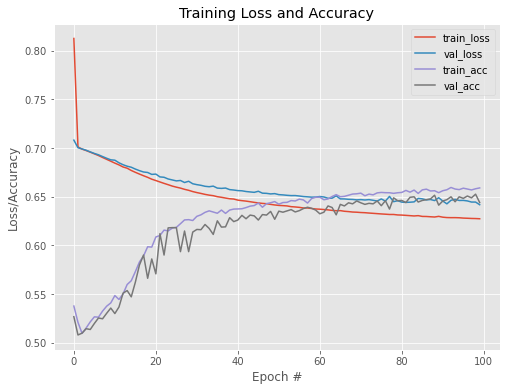

<Figure size 4320x7200 with 0 Axes>

In [15]:
# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

# compile the model, need to reduce lr to reduce overfit
#opt = Adam(lr=lr, decay=lr/epochs)
model_4.compile(
    optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr/10, beta_1=0.9, beta_2=0.999, epsilon=1e-07,decay=(lr/10)/epochs, amsgrad=False,
    name='Adam'
    ),
    loss=tf.keras.losses.BinaryCrossentropy(
    ),
    metrics=['accuracy'])
# train the model
H=model_4.fit(data,new_label, epochs=epochs,batch_size = batch_size,validation_split = 0.2      )
# save the model to disk
model_4.save("my_model5")

# plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.show()
# save plot to disk
plt.savefig("my_figures5")


# Xception

In [6]:
data,labels=load_h5_data("I_LUV_U.h5")

The keys are:  <KeysViewHDF5 ['image', 'label']>
The shape of x_field (18622, 96, 96, 3)
The shape of y_field (18622, 1)


(18622, 96, 96, 3)


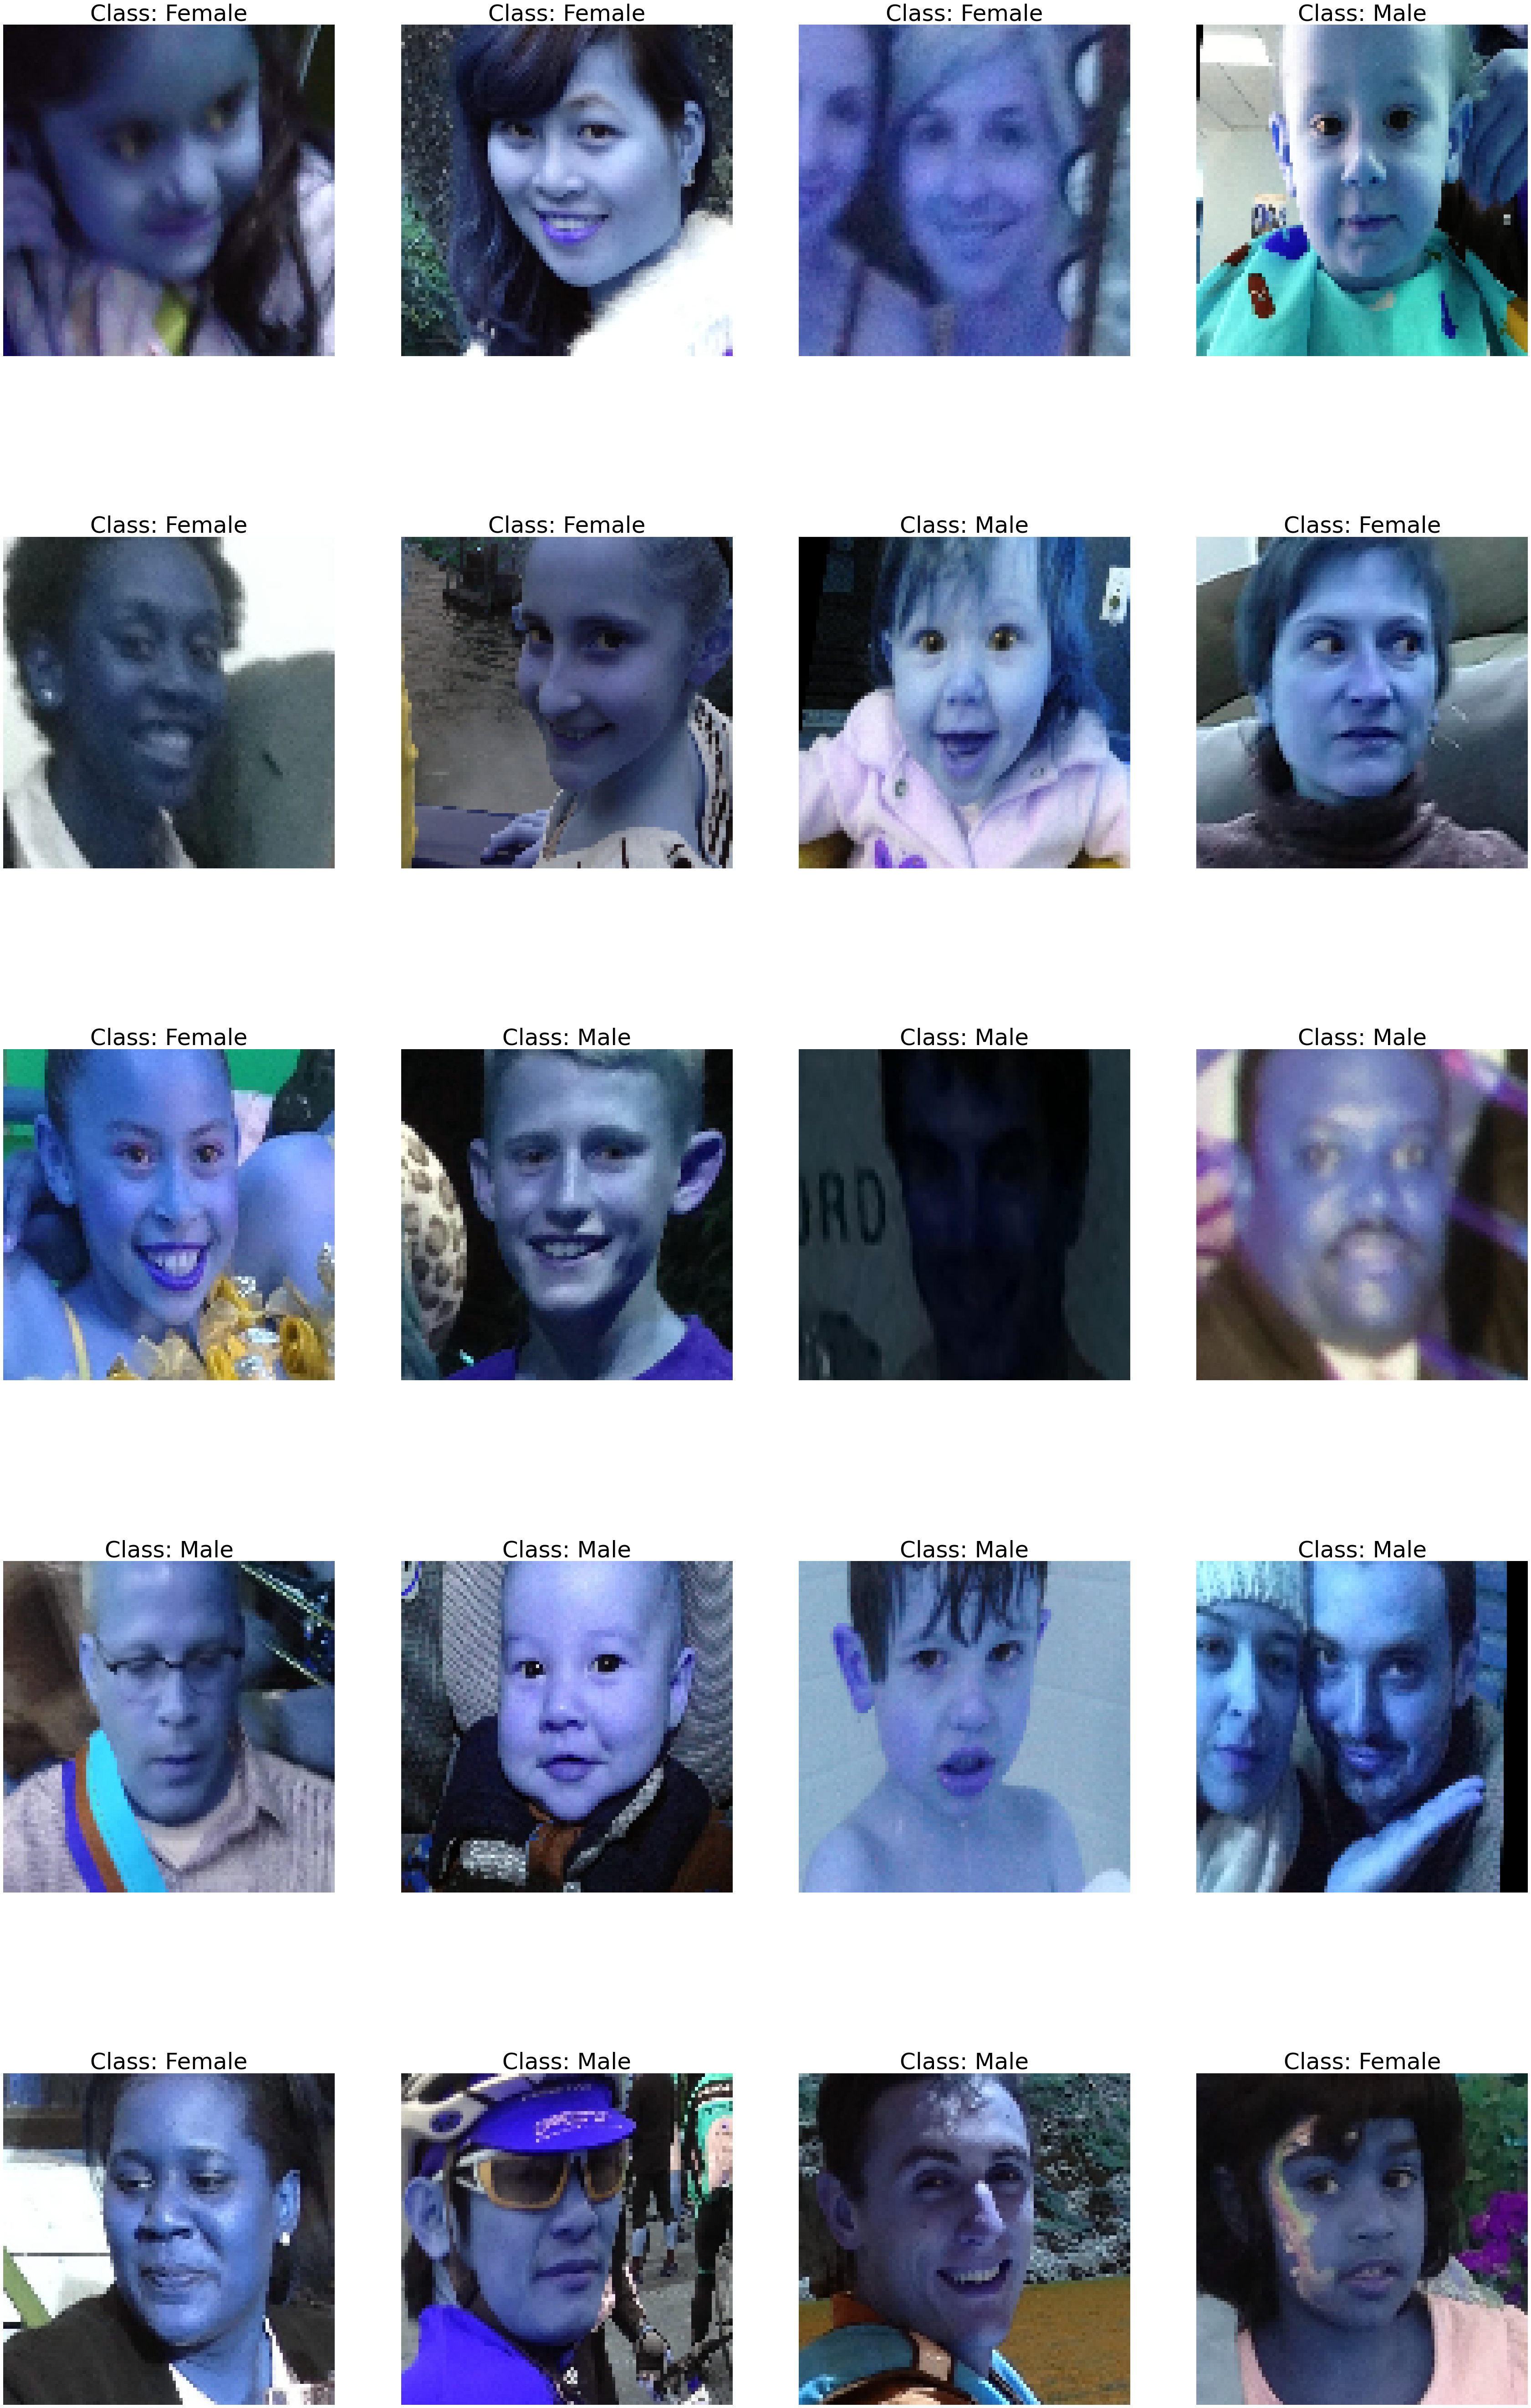

In [7]:
show_20_images(data,labels,20)

In [8]:
new_label = [i[0] for i in labels]
new_label = np.array(new_label)
print(new_label)

[1 0 1 ... 0 0 0]


In [9]:
perm = np.random.permutation(data.shape[0])
data = data[perm]
new_label = new_label[perm]
subset = 1024
trainX = data[:subset]
trainY = labels[:subset]

In [10]:
xception_net = tf.keras.applications.Xception(input_shape=(96,96,3),
                                               include_top=False,
                                               weights='imagenet')

In [11]:
xception_net.trainable=False

In [12]:
model_5=tf.keras.Sequential([
   xception_net, tf.keras.layers.GlobalAveragePooling2D(), tf.keras.layers.Dense(1)
])

In [13]:
model_5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


In [14]:
xception_net.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 47, 47, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 47, 47, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 47, 47, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

Epoch 1/100
233/233 [==============================] - 18s 79ms/step - loss: 1.7992 - accuracy: 0.5817 - val_loss: 1.5321 - val_accuracy: 0.6196
Epoch 2/100
233/233 [==============================] - 18s 77ms/step - loss: 1.5193 - accuracy: 0.6291 - val_loss: 1.4533 - val_accuracy: 0.6510
Epoch 3/100
233/233 [==============================] - 17s 74ms/step - loss: 1.3552 - accuracy: 0.6362 - val_loss: 1.3348 - val_accuracy: 0.6564
Epoch 4/100
233/233 [==============================] - 17s 74ms/step - loss: 1.8350 - accuracy: 0.6315 - val_loss: 1.4876 - val_accuracy: 0.6634
Epoch 5/100
233/233 [==============================] - 17s 73ms/step - loss: 1.3991 - accuracy: 0.6487 - val_loss: 1.4301 - val_accuracy: 0.6749
Epoch 6/100
233/233 [==============================] - 17s 74ms/step - loss: 1.3014 - accuracy: 0.6642 - val_loss: 1.3515 - val_accuracy: 0.6816
Epoch 7/100
233/233 [==============================] - 18s 76ms/step - loss: 1.2683 - accuracy: 0.6715 - val_loss: 1.3162 - val_ac

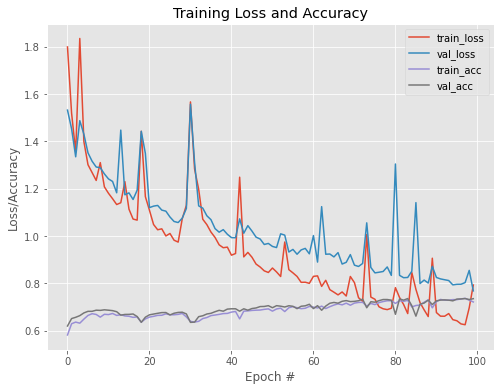

<Figure size 4320x7200 with 0 Axes>

In [15]:
# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

# compile the model, need to reduce lr to reduce overfit
#opt = Adam(lr=lr, decay=lr/epochs)
model_5.compile(
    optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr/10, beta_1=0.9, beta_2=0.999, epsilon=1e-07,decay=(lr/10)/epochs, amsgrad=False,
    name='Adam'
    ),
    loss=tf.keras.losses.BinaryCrossentropy(
    ),
    metrics=['accuracy'])
# train the model
H=model_5.fit(data,new_label, epochs=epochs,batch_size = batch_size,validation_split = 0.2      )
# save the model to disk
model_5.save("my_model6")

# plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.show()
# save plot to disk
plt.savefig("my_figures6")


## Gender Recognition using our model 

In [5]:
# read input image
image = cv2.imread("photo_2020-11-23_19-58-13.jpg")

if image is None:
    print("Could not read input image")
    exit()

# load pre-trained model
#Using our SmallerVGG without pretrain 
model = load_model("my_model2")
#model = load_model("Adience_model_fine.h5")

# detect faces in the image
face, confidence = cv.detect_face(image)

classes = ['man','woman']

# loop through detected faces
for idx, f in enumerate(face):

     # get corner points of face rectangle       
    (startX, startY) = f[0], f[1]
    (endX, endY) = f[2], f[3]

    # draw rectangle over face
    cv2.rectangle(image, (startX,startY), (endX,endY), (0,255,0), 2)

    # crop the detected face region
    face_crop = np.copy(image[startY:endY,startX:endX])

    # preprocessing for gender detection model
    face_crop = cv2.resize(face_crop, (96,96))
    face_crop = face_crop.astype("float") / 255.0
    face_crop = img_to_array(face_crop)
    face_crop = np.expand_dims(face_crop, axis=0)

    # apply gender detection on face
    conf = model.predict(face_crop)[0]
    print(conf)
    print(classes)

    # get label with max accuracy
    idx = np.argmax(conf)
    label = classes[idx]

    label = "{}: {:.2f}%".format(label, conf[idx] * 100)

    Y = startY - 10 if startY - 10 > 10 else startY + 10

    # write label and confidence above face rectangle
    cv2.putText(image, label, (startX, Y),  cv2.FONT_HERSHEY_SIMPLEX,
                0.7, (0, 255, 0), 2)

# display output
cv2.imshow("gender detection", image)

# press any key to close window           
cv2.waitKey()

# save output
cv2.imwrite("gender_detection.jpg", image)

# release resources
cv2.destroyAllWindows()

[9.9988866e-01 1.1128319e-04]
['man', 'woman']
[9.9996996e-01 2.9987026e-05]
['man', 'woman']
[0.9172522  0.08274749]
['man', 'woman']


# Appendix

In [ ]:
#If interested can access the resource from this link
#https://entuedu-my.sharepoint.com/:f:/g/personal/wli035_e_ntu_edu_sg/Er2t70cfz_lAmK7zLcLq8WYBRoDWQJmphYR60hG9tLOoYw?e=FFoSvy